# <h1> Movie Recommendation System <img src="https://www.pngall.com/wp-content/uploads/13/Movie-Hollywood-No-Background.png" width=200 style="vertical-align: middle"> </h1> 

## **Introduction**
Our team has been tasked with designing a state-of-the-art recommendation system that leverages advanced data analysis techniques to enhance user engagement. The project focuses on two critical areas: hashing techniques to optimize data retrieval speed and clustering algorithms to group users based on shared movie preferences. 
By combining these approaches, we aim to deliver faster, more accurate, and highly personalized movie recommendations that align with individual tastes and behaviors.This project not only addresses the technical challenges of scalability and precision in recommendation systems but also paves the way for deeper insights into user behavior, enabling a more immersive and satisfying entertainment experience.

<h3> <b> Import Libraries </b> <img src="https://preview.redd.it/snoovatar/avatars/nftv2_bmZ0X2VpcDE1NToxMzdfZWI5NTlhNzE1ZGZmZmU2ZjgyZjQ2MDU1MzM5ODJjNDg1OWNiMTRmZV8yMTQ1NzYzNg_rare_46f1cdb1-634f-4c1d-8344-2be06c7880d4-headshot.png?width=256&height=256&crop=smart&auto=webp&s=400ead9440c7a9f06ca4c44953f24c5b765c4aac" width=150 style="vertical-align: middle"> </h3>

In [1]:
!pip install pandas numpy tqdm seaborn 

import pandas as pd
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN

# 1.0 Recommendation System with LSH

In this section, we will implement a recommendation system by identifying users with similar preferences and suggesting movies based on their behavior. Specifically, we will implement our version of the **LSH algorithm**.

## 1.1 Data Preparation

In [7]:
import zipfile

# Path to the ZIP file
zip_file = "E:\MovieLens 20M Dataset.zip"

# Extract the file to the current directory
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall()  # "." means extract to the current directory

In [3]:
# Import rating dataset that contain userId,MovieId,Rating informations
rating=pd.read_csv("rating.csv")
rating.head()

userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40

In [4]:
# Show the Rating Dataset informations
rating.info,rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 610.4+ MB


(<bound method DataFrame.info of           userId  movieId  rating            timestamp
 0              1        2     3.5  2005-04-02 23:53:47
 1              1       29     3.5  2005-04-02 23:31:16
 2              1       32     3.5  2005-04-02 23:33:39
 3              1       47     3.5  2005-04-02 23:32:07
 4              1       50     3.5  2005-04-02 23:29:40
 ...          ...      ...     ...                  ...
 20000258  138493    68954     4.5  2009-11-13 15:42:00
 20000259  138493    69526     4.5  2009-12-03 18:31:48
 20000260  138493    69644     3.0  2009-12-07 18:10:57
 20000261  138493    70286     5.0  2009-11-13 15:42:24
 20000262  138493    71619     2.5  2009-10-17 20:25:36
 
 [20000263 rows x 4 columns]>,
 None)

In [5]:
# import the movie dataset with all movie title and genres
movie=pd.read_csv("movie.csv")
movie.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [6]:
# Define a function to obtain the film title without date
def splitter_title(text):
    text = text.split("(")[0]  
    text =  text.split(",")[0]  # let's also remove the comma
    text = text.strip()  # Remove any whitespace
    return text

In [7]:
# Apply the splitter_title function to the "title" column and store the result in "title2"
movie["title2"] = movie["title"].apply(splitter_title)

# Split the "genres" column by "|" and store the resulting list in "genre_list"
movie["genre_list"] = movie["genres"].str.split("|")

# Display the first 5 rows of the DataFrame to check the new columns
movie.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres                       title2  \
0  Adventure|Animation|Children|Comedy|Fantasy                    Toy Story   
1                   Adventure|Children|Fantasy                      Jumanji   
2                               Comedy|Romance             Grumpier Old Men   
3                         Comedy|Drama|Romance            Waiting to Exhale   
4                                       Comedy  Father of the Bride Part II   

                                          genre_list  
0  [Adventure, Animation, Children, Comedy, Fantasy]  
1                     [Adventure, Children, Fantasy]  
2                                  [Comedy, Romance]  
3                           [Comedy, Drama, Romance]  
4                                           [Comedy]

### Why we use `map` instead of `merge`?

In this context, `map` is used because it is computationally more efficient for simple one-to-one mappings compared to `merge`. Here's why:

1. **Performance**:  
   `map` is faster when you need to map a single column based on a key-value relationship, as it avoids the overhead of merging entire DataFrames.

2. **Memory Usage**:  
   `map` consumes less RAM memory since it only operates on the relevant column and does not create a new DataFrame, unlike `merge`.



In [8]:
# Map 'title2' column to 'Movie Title'
rating["Movie Title"] = rating['movieId'].map(movie.set_index('movieId')['title2'])

# Map 'genre_list' column to 'Genre'
rating["Genre"] = rating['movieId'].map(movie.set_index('movieId')['genre_list'])

In [9]:
rating.head()

userId  movieId  rating            timestamp            Movie Title  \
0       1        2     3.5  2005-04-02 23:53:47                Jumanji   
1       1       29     3.5  2005-04-02 23:31:16  City of Lost Children   
2       1       32     3.5  2005-04-02 23:33:39         Twelve Monkeys   
3       1       47     3.5  2005-04-02 23:32:07                  Seven   
4       1       50     3.5  2005-04-02 23:29:40         Usual Suspects   

                                          Genre  
0                [Adventure, Children, Fantasy]  
1  [Adventure, Drama, Fantasy, Mystery, Sci-Fi]  
2                   [Mystery, Sci-Fi, Thriller]  
3                           [Mystery, Thriller]  
4                    [Crime, Mystery, Thriller]

In [10]:
# Show the new Rating Dataset informations
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   userId       int64  
 1   movieId      int64  
 2   rating       float64
 3   timestamp    object 
 4   Movie Title  object 
 5   Genre        object 
dtypes: float64(1), int64(2), object(3)
memory usage: 915.5+ MB


<h4> <strong> Optimizing Data Types </strong> </h4>

Importance of Data Type Conversion

Converting `int64` to `int32` or `float64` to `float32` reduces memory usage, speeds up computations, and enables efficient handling of large datasets. This optimization saves resources and enhances performance in data processing.

In [11]:
# Loop through each column in the DataFrame
for column in rating.columns:
    # Convert types of rating DataFrame columns 
    if rating[column].dtype == 'int64':
        rating[column] = rating[column].astype('int32')
    elif rating[column].dtype == 'float64':
        rating[column] = rating[column].astype('float32')

In [12]:
# Show the new Rating Dataset informations
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   userId       int32  
 1   movieId      int32  
 2   rating       float32
 3   timestamp    object 
 4   Movie Title  object 
 5   Genre        object 
dtypes: float32(1), int32(2), object(3)
memory usage: 686.7+ MB


In [13]:
# Generate a statistical summary of the rating DataFrame
rating.describe()

userId       movieId        rating
count  2.000026e+07  2.000026e+07  2.000026e+07
mean   6.904587e+04  9.041567e+03  3.525529e+00
std    4.003863e+04  1.978948e+04  9.998490e-01
min    1.000000e+00  1.000000e+00  5.000000e-01
25%    3.439500e+04  9.020000e+02  3.000000e+00
50%    6.914100e+04  2.167000e+03  3.500000e+00
75%    1.036370e+05  4.770000e+03  4.000000e+00
max    1.384930e+05  1.312620e+05  5.000000e+00

In [14]:
# Check if there are NA values in the dataset
rating.isnull().sum()

userId         0
movieId        0
rating         0
timestamp      0
Movie Title    0
Genre          0
dtype: int64

### Information about the dataset

#### 1. **Time range and the number of movies released for each year**

In [15]:
# Convert the "timestamp" column to datetime format
rating["timestamp"] = pd.to_datetime(rating["timestamp"])

# Calculate the time range in years and print it with better formatting
time_range_years = rating["timestamp"].max().year - rating["timestamp"].min().year
print(f"The dataset covers a time range of {time_range_years} years, from {rating['timestamp'].min().year} to {rating['timestamp'].max().year}")

The dataset covers a time range of 20 years, from 1995 to 2015


In [16]:
# Define a new column with only year of timestamp column
rating['year'] = rating['timestamp'].dt.year

# Count unique movies per year
movies_per_year = rating.drop_duplicates(subset='Movie Title')['year'].value_counts().sort_index()

# Show the results
print(movies_per_year)

year
1996     329
1997     143
1998      99
1999     769
2000     480
2001     661
2002    1017
2003     538
2004     483
2005    1109
2006     504
2007    1252
2008     762
2009    1487
2010    1810
2011    2175
2012    2276
2013    2440
2014    3634
2015    2912
Name: count, dtype: int64


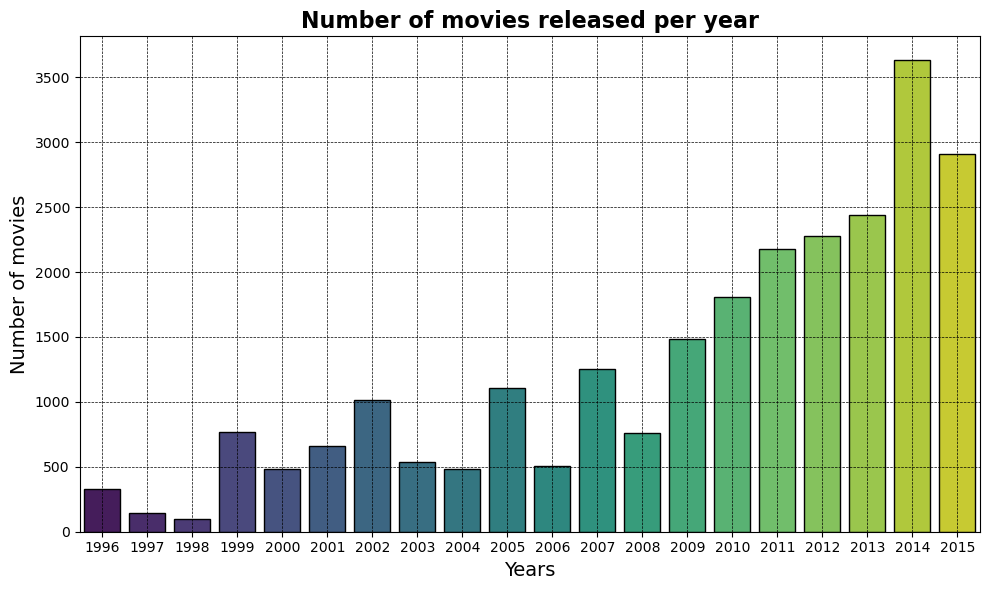

In [17]:
# Create a bar chart to see the number of movies released for each year

plt.figure(figsize=(10, 6))
sns.barplot(x=movies_per_year.index, y=movies_per_year.values, palette='viridis',edgecolor="black")  
plt.title('Number of movies released per year', fontsize=16, fontweight='bold')
plt.xlabel('Years', fontsize=14)
plt.ylabel('Number of movies', fontsize=14)

plt.grid(linestyle='--',linewidth=0.5,color="black")
plt.tight_layout()
plt.show()

The graph shows a clear upward trend in the number of movies released per year, with a significant spike in 2014 reaching over 3,000 movies. The data suggests that the movie industry has experienced substantial growth and expansion over the past two decades, with an increasing number of films being produced and released annually.

#### 2. **Number of reviews per user**

In [18]:
# Group by 'userId', count the number of ratings each user has, and sort in descending order
user_rating_counts = rating.groupby('userId')['rating'].apply(len).sort_values(ascending=False)

# Print the results with clear labels
print(f"Top 5 users with the most ratings:\n{user_rating_counts.head(5)}")
print(f"\nBottom 5 users with the fewest ratings:\n{user_rating_counts.tail(5)}")

Top 5 users with the most ratings:
userId
118205    9254
8405      7515
82418     5646
121535    5520
125794    5491
Name: rating, dtype: int64

Bottom 5 users with the fewest ratings:
userId
89305     20
110463    20
96990     20
134747    20
6526      20
Name: rating, dtype: int64


There are users who have watched more than 5000 different movies. Probably those who have watched so many movies are usually film critics, journalists or extremely dedicated film enthusiasts.

In [19]:
# Show more information about user_rating_counts
user_rating_counts.describe().astype(np.int32)

count    138493
mean        144
std         230
min          20
25%          35
50%          68
75%         155
max        9254
Name: rating, dtype: int32

#### 3. **TOP 5 Movies with the most number of ratings**

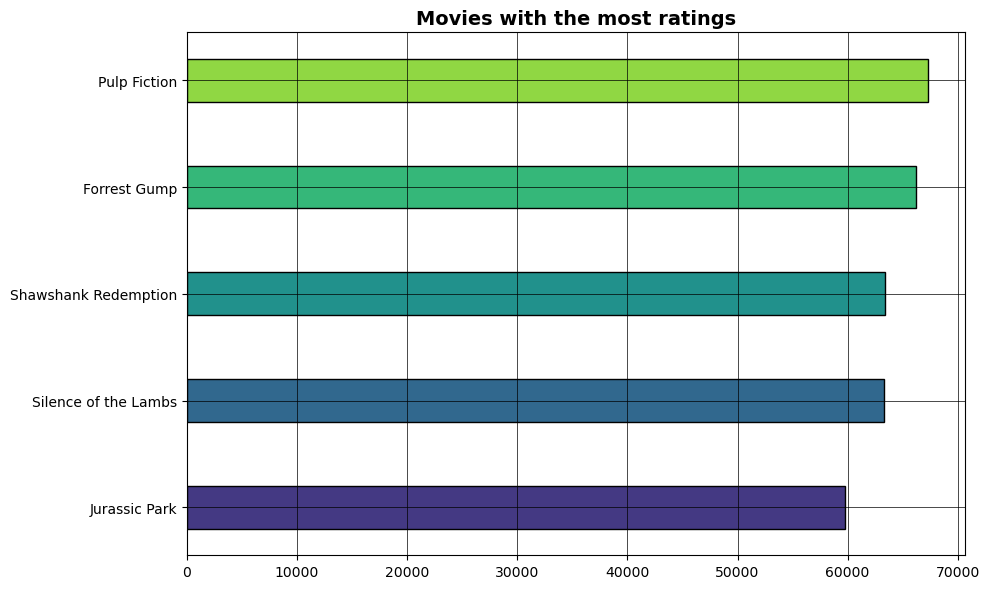

In [20]:
highest_rated_movies=rating.groupby("Movie Title")["rating"].apply(len).sort_values(ascending=False).head(5)

# Plot the graph 

viridis = sns.color_palette("viridis",len(highest_rated_movies))
plt.figure(figsize=(10,6))
highest_rated_movies[::-1].plot.barh(width=0.4, color=viridis,edgecolor="black")

plt.title("Movies with the most ratings",fontsize=14,weight="bold")
plt.ylabel('')
plt.tick_params("y",labelsize=10)

plt.tight_layout()
plt.grid(linestyle='-',linewidth=0.5,color="black")
plt.show()

In [21]:
for position, (movie, value) in enumerate(highest_rated_movies.items(), start=1):
    print(f"Movie in position {position} is {movie} with a numbers of ratings equal to {value}")

Movie in position 1 is Pulp Fiction with a numbers of ratings equal to 67310
Movie in position 2 is Forrest Gump with a numbers of ratings equal to 66172
Movie in position 3 is Shawshank Redemption with a numbers of ratings equal to 63366
Movie in position 4 is Silence of the Lambs with a numbers of ratings equal to 63299
Movie in position 5 is Jurassic Park with a numbers of ratings equal to 59715


# 1.2.0 Minhash Signatures

This function will **hash** each user's watched movie list to create a **signature vector**, which provides a compact representation of the user's preferences. By using **MinHash**, we can generate these signature vectors based on the movies that each user has rated. The key advantage of using MinHash is that it allows for **quick comparisons** of user similarity without directly comparing their entire lists of movies.

### Steps:
1. **Hash User's Movie List**: For each user, we generate a hash based on their watched movies.
2. **MinHash Signatures**: The MinHash function creates a **signature vector** for each user, which is a compressed version of their movie list.
3. **Efficient Similarity Comparison**: These signature vectors make it faster to compare users, enabling quick identification of similar users based on their movie preferences.


In [22]:
# Group the 'rating' DataFrame by 'userId', then apply 'set()' to the 'movieId' for each user.
user_movies=rating.groupby('userId')['movieId'].apply(set).to_dict()
print("User Movies:")
for user, movies in list(user_movies.items())[:5]:  # Display the first 5 users
    print(f"User {user}: {movies}")

User Movies:
User 1: {2, 3081, 4105, 1036, 5146, 541, 29, 32, 4128, 4133, 47, 1584, 5679, 50, 5171, 2100, 1079, 1080, 1089, 1090, 2628, 2118, 1097, 589, 7757, 7247, 593, 3153, 2644, 2648, 2138, 2140, 2143, 6242, 6754, 6755, 2664, 112, 1136, 4720, 6774, 2683, 2173, 2174, 4226, 2692, 653, 2193, 2194, 4754, 151, 6807, 2716, 5797, 1193, 1196, 1198, 1200, 1201, 6834, 8368, 1208, 5816, 6333, 1214, 1215, 1217, 3265, 1219, 1222, 2761, 2762, 2253, 4306, 1750, 1240, 1243, 7387, 7389, 1246, 223, 1249, 6888, 1258, 1259, 1261, 1262, 2288, 1266, 2291, 2804, 253, 1278, 8961, 260, 5898, 1291, 4878, 7438, 1304, 7449, 7454, 4896, 8482, 293, 296, 1321, 4911, 3889, 4915, 1333, 1848, 2872, 7482, 8507, 318, 5952, 1348, 1350, 4941, 1358, 337, 7001, 1370, 3932, 1374, 4446, 2918, 6502, 1387, 3438, 367, 5999, 4467, 4980, 1920, 2944, 4993, 2947, 7045, 7046, 6539, 2959, 3476, 919, 2968, 3479, 924, 3996, 3997, 3489, 5026, 5540, 3499, 4011, 1967, 5039, 5040, 3000, 4027, 8636, 1994, 1997, 6093, 31696, 3030, 4571, 30

MinHash is a technique used for approximating the similarity between sets, such as the set of movies each user has watched in a recommendation system. It uses multiple hash functions to generate **signature vectors** that represent the set of movies a user has rated.

For the MinHash we defined three different type of Hash function. In details:

## The three Hash Functions:

### 1. **Linear Hash Function**
The **linear** hash function is the simplest type, using the formula:

$ Hash(x) = (a \cdot x + b) \mod p $

Where:
- **a** and **b** are random coefficients ;
- **p** is a prime number (for example 10513) ;
- **x** is the movie ID.

The idea behind this hash function is to perform a linear transformation of the movie ID, and then take the result modulo p. This produces a unique integer for each movie, which is used to create the signature.

---

### 2. **Polynomial Hash Function**
The **polynomial** hash function works similarly to the linear function, but instead of a simple linear transformation, it applies polynomial powers to the movie ID. The formula is:

$ Hash(x) =  \sum_{i=0}^{n} c_i \cdot (x^i) \mod p $

Where:
- $\mathbf{c_{i}}$ are random coefficients for each power of x ;
- **p** is a prime number (for example 10513) ;
- **n** is the degree of the polynomial ;
- **x** is the movie ID.

In this case, the movie ID is raised to successive powers, with each term multiplied by a corresponding random coefficient. The sum is then taken modulo **p**.

---

### 3. **Universal Hash Function**
The **universal** hash function is a more advanced form of hashing that uses `double hashing` to reduce the probability of collisions in a hash table. The idea is to apply two hash functions and combine the results to get a more uniform distribution of hashes.
The second hash function applies an additional step using the value obtained from the first function ($ Hash_1(x) $ ) and a larger modulus m.

$ Hash_1(x) $ = $ ((a \cdot x + b) \mod p) $  

$ Hash_2(x) $ = $ ((a \cdot Hash_1(x) + b) \mod m) $  

$ Hash_{1,2}(x)=(Hash_1(x)+Hash_2(x)) \mod m $

Where:
- **a** and **b** are random coefficients ;
- **p** is a prime number (for example 10513) ;
- **m** is the modulus used to limit the hash output to a specific range. It is generally a prime number larger than the modulus used in the first hash function to reduce the risk of collisions.

### MinHash Process:

1. **Random Coefficients** : For each hash function, random values a and b are generated within the range of the modulus p ;
   
2. **Hashing Process** : For each movie in the user's watched list, apply the formula \hash(x) for each hash function. This results in a unique integer value (hash) for each movie ;

3. **Signature Vector** : The minimum hash value for each of the hash functions is selected from the set of movie hashes. This set of minimum values across all hash functions forms the **signature vector** for the user.


In [23]:
from minhash_similarity import MinHash

# Show the informations about the two functions of the MinHash module:
help(MinHash)

Help on class MinHash in module minhash_similarity:

class MinHash(builtins.object)
 |  MinHash(n_hash_functions: int = 100, prime_number: int = 10513, type_function: str = 'linear')
 |  
 |  Methods defined here:
 |  
 |  __init__(self, n_hash_functions: int = 100, prime_number: int = 10513, type_function: str = 'linear')
 |      Initialize MinHash with a specified number of hash functions.
 |      
 |      Args:
 |          n_hash_functions: Number of hash functions to use for creating signatures (default is 100)
 |          prime: A higher prime number for the hash function (default is 10513)
 |          type_function: Type of hash function to use ('linear', 'universal', 'polynomial')
 |  
 |  create_signature(self, movie_set)
 |      Create MinHash signature for a set of movies.
 |      
 |      Args:
 |          movie_set: Set of movie IDs
 |          
 |      Returns:
 |          np.ndarray: MinHash signature (array of minimum hash values)
 |  
 |  hash_function(self, x, a, b, i)

### **Minhash signatures and Jaccard Similarity**

In [24]:
def generate_signatures(user_movies: dict, num_hash_function: int,function_name: str):

    minhash=MinHash(num_hash_function,type_function=function_name)
     # Initialize an empty dictionary to store the MinHash signatures for each user.
    signatures = {}

    # Iterate over each user and their associated movie set in the `user_movies` dictionary.
    # Use tqdm to display a progress bar for tracking the loop's progress.

    for user_id, movies in tqdm(user_movies.items(), desc="Generating Signatures", total=len(user_movies)):
        signatures[user_id] = minhash.create_signature(movies)   # Generate a MinHash signature for the current user's movie set and store it.
    return signatures

**Jaccard Similarity** (or Jaccard Index) is a statistical measure used to compare the similarity and diversity between two sets. It is commonly used to calculate the similarity between two sets of items, such as the sets of movies watched by two users in a recommendation system.

## Formula:

The formula to calculate Jaccard Similarity between two sets A and B is as follows:

$$\ J(A, B) = \frac{|A \cap B|}{|A \cup B|}\$$

Where:
- \|A $\cap B|$ is the **cardinality of the intersection** of A and B , the number of elements common to both sets.
- \|A $\cup B|$ is the **cardinality of the union** of  A and B , the total number of elements present in at least one of the two sets.


In [25]:
def exact_jaccard_similarity(sig1, sig2):
    """
    sig1 : the signature of the user 1
    sig2 : the signature of the user 2
    """
    intersection = len(sig1 & sig2)
    union = len(sig1 | sig2)
    return intersection / union # Returns Jaccard similarity value between 0 and 1

### `compute_similarities` function

This function calculates Jaccard similarity between randomly sampled user pairs (5000 samples) to reduce computation time. Instead of comparing all users, it randomly selects a subset for similarity calculation using MinHash. 

Pairs with estimated Jaccard similarity above a given threshold (0.6) are considered similar.

- **Random Sampling:** 5000 random user pairs are selected ;
- **Thresholding:** Pairs with estimated similarity above the threshold are counted as similar. Jaccard similarity is calculated only for users above this threshold to reduce computational overhead, ignoring other user pairs with lower similarity.
- **Outputs:** The function prints the most similar pairs, average loss and the count of similar/non-similar user pairs.

**Considerations**

We chose this sample size to evaluate whether the Jaccard similarities estimated by the algorithm align with the real Jaccard similarities of the users. Conducting a complete analysis involving all users would have required nearly 10 billion comparisons, making it hard computationally.


In [26]:
def compute_similarities(user_signatures, user_movies, max_results=10, similarity_threshold=0.6, hash_functions=100):

    # Set a random seed for reproducibility of results
    np.random.seed(213242)
    
    # Select 1000 random user IDs to compute similarities
    user_ids = np.random.choice(range(1, len(user_movies) + 1), 5000, replace=False)
    
    # Initialize dictionaries to store similarities and losses
    similarities, losses = {}, []

    # Create MinHash instance 
    minhash = MinHash(n_hash_functions=hash_functions)

    for i in range(len(user_ids)):
        for j in range(i + 1, len(user_ids)):
            
            # Estimate Jaccard similarity using MinHash signatures
            est_sim = minhash.jaccard_similarity(user_signatures[user_ids[i]], user_signatures[user_ids[j]])
            
            # Filter pairs above certain similarity threshold
            if est_sim > similarity_threshold:

                # Compute exact Jaccard similarity
                exact_sim = exact_jaccard_similarity(user_movies[user_ids[i]], user_movies[user_ids[j]])
                
                # Calculate loss between estimated and exact similarities
                loss = abs(est_sim - exact_sim)
                losses.append(loss)
                
                # Store similarity information
                similarities[(user_ids[i], user_ids[j])] = (est_sim, exact_sim, loss)
    
    # Sort similarities by estimated similarity in descending order
    sorted_sims = sorted(similarities.items(), key=lambda x: x[1][0], reverse=True)[:max_results]
    
    # Print details of top similar user pairs
    for (user1, user2), (est_sim, exact_sim, loss) in sorted_sims:
        print(f"Users: ({user1}, {user2}) --> Estimated: {est_sim:.2f}, Exact: {exact_sim:.2f}, Loss: {loss:.2f}")
    
    # Calculate average loss
    avg_loss = np.mean(losses) 
    print(f"\nAverage Loss: {avg_loss:.4f}")
    print(f"\nNumber of similar user pairs (estimated similarity > {similarity_threshold}): {len(losses)}, Number of non similar user pairs is {len(user_ids) * (len(user_ids) - 1) // 2 }")

In [25]:
# Print and generate signatures with different types of hash functions and 50 hash functions

# Using Linear hash functions

print("Generating signatures with Linear hash function --> 50 hash functions:")
signatures_linear_50 = generate_signatures(user_movies, 50 , function_name='linear')
print("-" * 80)

# Using Universal hash functions

print("Generating signatures with Universal hash function --> 50 hash functions:")
signatures_universal_50 = generate_signatures(user_movies, 50 , function_name='universal')
print("-" * 80)

# Using Polynomial hash functions

print("Generating signatures with Polynomial hash function --> 50 hash functions:")
signatures_polynomial_50 = generate_signatures(user_movies, 50 , function_name='polynomial')


Generating signatures with Linear hash function --> 50 hash functions:


Generating Signatures: 100%|██████████| 138493/138493 [00:57<00:00, 2423.45it/s]


--------------------------------------------------------------------------------
Generating signatures with Universal hash function --> 50 hash functions:


Generating Signatures: 100%|██████████| 138493/138493 [01:21<00:00, 1694.36it/s]


--------------------------------------------------------------------------------
Generating signatures with Polynomial hash function --> 50 hash functions:


Generating Signatures: 100%|██████████| 138493/138493 [01:04<00:00, 2156.52it/s]


In [26]:
# Show the top five userID and their signatures compared to their original MovieID sets
for userid in list(signatures_linear_50.keys())[:5]:
    print(f"\n -- User {userid} --")
    print(f"Movie IDs (before signature): {user_movies[userid]}")  
    print(f"MinHash signature: {list(signatures_linear_50[userid])}")


 -- User 1 --
Movie IDs (before signature): {2, 3081, 4105, 1036, 5146, 541, 29, 32, 4128, 4133, 47, 1584, 5679, 50, 5171, 2100, 1079, 1080, 1089, 1090, 2628, 2118, 1097, 589, 7757, 7247, 593, 3153, 2644, 2648, 2138, 2140, 2143, 6242, 6754, 6755, 2664, 112, 1136, 4720, 6774, 2683, 2173, 2174, 4226, 2692, 653, 2193, 2194, 4754, 151, 6807, 2716, 5797, 1193, 1196, 1198, 1200, 1201, 6834, 8368, 1208, 5816, 6333, 1214, 1215, 1217, 3265, 1219, 1222, 2761, 2762, 2253, 4306, 1750, 1240, 1243, 7387, 7389, 1246, 223, 1249, 6888, 1258, 1259, 1261, 1262, 2288, 1266, 2291, 2804, 253, 1278, 8961, 260, 5898, 1291, 4878, 7438, 1304, 7449, 7454, 4896, 8482, 293, 296, 1321, 4911, 3889, 4915, 1333, 1848, 2872, 7482, 8507, 318, 5952, 1348, 1350, 4941, 1358, 337, 7001, 1370, 3932, 1374, 4446, 2918, 6502, 1387, 3438, 367, 5999, 4467, 4980, 1920, 2944, 4993, 2947, 7045, 7046, 6539, 2959, 3476, 919, 2968, 3479, 924, 3996, 3997, 3489, 5026, 5540, 3499, 4011, 1967, 5039, 5040, 3000, 4027, 8636, 1994, 1997, 609

<h4> Now we compute the similarities for the three Hash Functions using the previously defined function for each set of signatures with a different number of hash functions </h4>
 

In [27]:
# 1. Linear
print("Similarities with Linear Hash Function --> 50 Hash Functions:")
print(compute_similarities(signatures_linear_50, user_movies, hash_functions=50))

Similarities with Linear Hash Function --> 50 Hash Functions:
Users: (41335, 19403) --> Estimated: 1.00, Exact: 1.00, Loss: 0.00
Users: (35593, 82226) --> Estimated: 0.98, Exact: 0.97, Loss: 0.01
Users: (45329, 87892) --> Estimated: 0.98, Exact: 0.95, Loss: 0.03
Users: (35593, 125825) --> Estimated: 0.92, Exact: 0.87, Loss: 0.05
Users: (106591, 65619) --> Estimated: 0.90, Exact: 0.76, Loss: 0.14
Users: (82226, 125825) --> Estimated: 0.90, Exact: 0.84, Loss: 0.06
Users: (92201, 59771) --> Estimated: 0.88, Exact: 0.78, Loss: 0.10
Users: (41335, 44284) --> Estimated: 0.88, Exact: 0.83, Loss: 0.05
Users: (19403, 44284) --> Estimated: 0.88, Exact: 0.83, Loss: 0.05
Users: (49437, 23147) --> Estimated: 0.88, Exact: 0.79, Loss: 0.09

Average Loss: 0.0734

Number of similar user pairs (estimated similarity > 0.6): 1668, Number of non similar user pairs is 12497500
None


In [28]:
# 2. Universal
print("Similarities with Universal Hash Function --> 50 Hash Functions:")
print(compute_similarities(signatures_universal_50, user_movies, hash_functions=50))

Similarities with Universal Hash Function --> 50 Hash Functions:
Users: (41335, 19403) --> Estimated: 1.00, Exact: 1.00, Loss: 0.00
Users: (35593, 82226) --> Estimated: 1.00, Exact: 0.97, Loss: 0.03
Users: (45329, 87892) --> Estimated: 0.94, Exact: 0.95, Loss: 0.01
Users: (17104, 59771) --> Estimated: 0.90, Exact: 0.81, Loss: 0.09
Users: (35593, 15068) --> Estimated: 0.90, Exact: 0.83, Loss: 0.07
Users: (35593, 125825) --> Estimated: 0.90, Exact: 0.87, Loss: 0.03
Users: (99578, 1101) --> Estimated: 0.90, Exact: 0.76, Loss: 0.14
Users: (82226, 15068) --> Estimated: 0.90, Exact: 0.80, Loss: 0.10
Users: (82226, 125825) --> Estimated: 0.90, Exact: 0.84, Loss: 0.06
Users: (44284, 97333) --> Estimated: 0.90, Exact: 0.83, Loss: 0.07

Average Loss: 0.0927

Number of similar user pairs (estimated similarity > 0.6): 2016, Number of non similar user pairs is 12497500
None


In [29]:
# 3. Polynomial 
print("Similarities with Polynomial Hash Function --> 50 Hash Functions:")
print(compute_similarities(signatures_polynomial_50, user_movies, hash_functions=50))

Similarities with Polynomial Hash Function --> 50 Hash Functions:
Users: (41335, 19403) --> Estimated: 1.00, Exact: 1.00, Loss: 0.00
Users: (35593, 82226) --> Estimated: 0.98, Exact: 0.97, Loss: 0.01
Users: (33332, 84928) --> Estimated: 0.96, Exact: 0.88, Loss: 0.08
Users: (45329, 87892) --> Estimated: 0.94, Exact: 0.95, Loss: 0.01
Users: (67478, 28968) --> Estimated: 0.90, Exact: 0.87, Loss: 0.03
Users: (92201, 59771) --> Estimated: 0.88, Exact: 0.78, Loss: 0.10
Users: (102028, 97333) --> Estimated: 0.88, Exact: 0.83, Loss: 0.05
Users: (135966, 97333) --> Estimated: 0.88, Exact: 0.88, Loss: 0.01
Users: (15938, 63813) --> Estimated: 0.86, Exact: 0.74, Loss: 0.12
Users: (15938, 45868) --> Estimated: 0.86, Exact: 0.77, Loss: 0.09

Average Loss: 0.0795

Number of similar user pairs (estimated similarity > 0.6): 1520, Number of non similar user pairs is 12497500
None


# MinHash Similarity Comparison

---

### 1. **Linear Hash Function (50 Hash Functions)**
- The linear hash function has the **lowest average loss** among the three. This indicates that its similarity estimates are consistently close to the true values.
- Given its balance between accuracy and computational efficiency, it is the **best choice** for applications that require a good trade-off between accuracy and processing time.

---

### 2. **Universal Hash Function (50 Hash Functions)**
- The universal hash function has a **computational complexity similar to the linear one**. In our tests, the **average loss is unstable**, in most cases it was slightly higher among the other functions with a loss of 0.1, although it can also achieve a lower loss. It remains a good alternative to the linear hash function 
---

### 3. **Polynomial Hash Function (50 Hash Functions)**
- The polynomial hash function shows a **relatively low average loss**, but is the **most computationally expensive** of the three. It is a good alternative when higher precision is needed, but with a higher computational cost than the linear function.
---

### **Conclusion**
- The linear hash function is the best choice, with the lowest average loss and good computational performance.

<h3> To further improve the similarity and reduce the average loss, we increase the number of Hash functions for the linear. </h3>

In details:
- We define signatures for each user id with a higher number of Hash functions (100,200). We expect that higher number of functions will lead to higher computational cost but very high accuracy ;
- We calculate the estimated Jaccard with 100,200 Hash functions and observe the differences from the exact Jaccard between different users ;
- Let's compare the results by looking at the average loss calculated on a random sample of 5000 users as a metric ;

In [164]:
# Let's try with 100 and 200 functions to see if the avg loss will be lower

# The length of the signature increases further, improving the similarity
signatures_linear_100 = generate_signatures(user_movies, 100,function_name='linear')

print("-" * 80) 

# Much more detailed signature, suitable for the scenario where high precision is needed
# It is the most expensive in terms of memory and computation.
signatures_linear_200 = generate_signatures(user_movies, 200,function_name='linear')

Generating Signatures: 100%|██████████| 138493/138493 [00:59<00:00, 2308.41it/s]


--------------------------------------------------------------------------------


Generating Signatures: 100%|██████████| 138493/138493 [04:23<00:00, 526.39it/s] 


<h3> Compare similarity for 100-200 number of Hash Functions </h3>

In [43]:
print("Similarities with 100 Hash Functions:")
print(compute_similarities(signatures_linear_100,user_movies,hash_functions=100))

print("-" * 80)

print("Similarities with 200 Hash Functions:")
print(compute_similarities(signatures_linear_200,user_movies,hash_functions=200))

Similarities with 100 Hash Functions:
Users: (41335, 19403) --> Estimated: 1.00, Exact: 1.00, Loss: 0.00
Users: (45329, 87892) --> Estimated: 0.96, Exact: 0.95, Loss: 0.01
Users: (35593, 82226) --> Estimated: 0.95, Exact: 0.97, Loss: 0.02
Users: (33332, 104843) --> Estimated: 0.93, Exact: 0.84, Loss: 0.09
Users: (44284, 97333) --> Estimated: 0.91, Exact: 0.83, Loss: 0.08
Users: (135966, 97333) --> Estimated: 0.90, Exact: 0.88, Loss: 0.03
Users: (82226, 45868) --> Estimated: 0.89, Exact: 0.85, Loss: 0.04
Users: (11388, 63279) --> Estimated: 0.88, Exact: 0.85, Loss: 0.03
Users: (26219, 82226) --> Estimated: 0.87, Exact: 0.87, Loss: 0.00
Users: (35593, 125825) --> Estimated: 0.87, Exact: 0.87, Loss: 0.00

Average Loss: 0.0470

Number of similar user pairs (estimated similarity > 0.6): 1478, Number of non similar user pairs is 12497500
None
--------------------------------------------------------------------------------
Similarities with 200 Hash Functions:
Users: (41335, 19403) --> Estima

# 1.3.0 Locality-Sensitive Hashing (LSH)

Our approach leverages Locality-Sensitive Hashing (LSH) with 200 hash functions to efficiently compute user similarities at scale. By generating compact signatures for each user, we dramatically reduce computational complexity from O(n²) to near-linear time.

Key implementation details:

1. 200 hash functions create robust user signatures
2. Low average loss ensures high-quality similarity detection

The LSH model transforms the Jaccard similarity computation among the 138,000 users of the dataset, reducing the complexity from O(n²) to O(num_bands $\cdot$ rows_per_band + k) where:
- **num_bands** is the number of bands the signature is divided into ;
- **rows_per_band** is the number of rows per band (i.e., the length of each portion of the signature) ;
- **k** is the number of candidate users found in the same matching buckets.

This approach enables efficient analysis of the large-scale user network by minimizing computational overhead, preserving similarity patterns, and converting numerous pairwise comparisons into a fast approximation linear method.

**Bucket Creation:** For each user, divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets.

In [168]:
from locality_sensitive_hashing import LSH
help(LSH)

Help on class LSH in module locality_sensitive_hashing:

class LSH(builtins.object)
 |  LSH(num_bands: int, rows_per_band: int)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, num_bands: int, rows_per_band: int)
 |      Initialize the Locality Sensitive Hashing (LSH) object.
 |      
 |      Args:
 |          num_bands (int): Number of bands to divide signatures into.
 |          rows_per_band (int): Number of rows (hash values) in each band.
 |  
 |  build_buckets(self, signatures: dict)
 |      Build hash buckets by dividing signatures into bands.
 |      
 |      This method populates the buckets with user IDs that have similar 
 |      signature bands. It helps in quickly finding similar items by 
 |      reducing the search space.
 |      
 |      Args:
 |          signatures (dict): Dictionary with user IDs as keys and signature arrays as values.
 |      Returns:
 |              None
 |  
 |  create_bucket_hash(self, band_index: int, band_signature: list)
 |      Create a 

### Optimal number of Bands and Rows for 200 Hash Functions

Given a signature matrix with **200 hash functions**, the total number of rows \( n \) is fixed at 200. The number of **bands (b)** and **rows per band (r)** must satisfy the equation:

$ n = b \times r $

---

#### Choosing the optimal numbers of bands and rows per band
  **Balance False Positives and False Negatives:**  
   - Fewer bands (b) and more rows per band (r) reduce false positives but increase false negatives;
   - More bands and fewer rows per band reduce false negatives but increase false positives.

We chose **10 bands** \( b = 10 \) and **20 rows per band** \( r = 20 \). Using fewer bands reduces the computational cost compared to configurations with more bands, while 20 rows per band ensures enough to reduce the impact of noise in the hash signatures.



In [305]:
# Initialize LSH with 20 bands, 10 rows per band
lsh_model = LSH(num_bands=20, rows_per_band=10)
    
# Build buckets from signatures with 200 hash functions
lsh_model.build_buckets(signatures_linear_200)

1. **Bucket Creation**: For each user, we divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets;

2. **Debug** : After creating buckets, we check bucket contents to verify that multiple users are being grouped in the same buckets.

In [313]:
# .view_buckets of LSH class show 10 random buckets and their respect contents
lsh_model.view_buckets()

Bucket LSH-049206: [17279, 63055, 69931, 102212]
Bucket LSH-246830: [26885, 122889]
Bucket LSH-948214: [18767, 73300, 73588, 138083]
Bucket LSH-281432: [35484, 82593, 88039, 90946]
Bucket LSH-938311: [2461, 24357, 57227]
Bucket LSH-898788: [17119, 23576, 82297, 85249, 97281]
Bucket LSH-356645: [26813, 59193, 69251, 74141, 104748]
Bucket LSH-432115: [66635, 71998, 103013, 116223, 116825]
Bucket LSH-789609: [50123, 105593]
Bucket LSH-722364: [34984, 35357, 41760]


<h3> <strong> Query: </strong> for a given user, identify the two most similar users based on their bucket placement </h3>


In [ ]:
# Randomly select a user ID
user_id = random.randint(1, len(user_movies))

# Get the query user's signature
query_signature = signatures_linear_200[user_id]

# Query for similar users using LSH
similar_users = lsh_model.query(query_signature, user_id)

# Sort the similar users by exact Jaccard similarity in descending order
sorted_similar_users = sorted(similar_users, key=lambda x: exact_jaccard_similarity(user_movies[user_id], user_movies[x]), reverse=True)

# Get the top 2 most similar users
top_2_similar_users = sorted_similar_users[:2]

print(f"Set of all similars users of user {user_id} : {set(similar_users)} ")
print(f"number of similar users: {len(similar_users)}")

# Show the two most similar users with them exact jaccard similarity with user id 
print(f"\nThe two most similar users of user {user_id} are: {top_2_similar_users}, "
      f"user {top_2_similar_users[0]} similarity: {exact_jaccard_similarity(set(user_movies[user_id]), set(user_movies[top_2_similar_users[0]])):.2f}, "
      f"user {top_2_similar_users[1]} similarity: {exact_jaccard_similarity(set(user_movies[user_id]), set(user_movies[top_2_similar_users[1]])):.2f}")

Set of all similars users of user 116368 : {15365, 60935, 55305, 90641, 20514, 110116, 32807, 118827, 66095, 50231, 30796, 129108, 89689, 130663, 47719, 40046, 134263, 12924, 129667, 2191, 2706, 33942, 10906, 64666, 79516, 131236, 58053, 44249, 134365, 22752, 50401, 57571, 79086, 55039, 56585, 81674, 29460, 104732, 120103, 112939, 96558, 12595, 112953, 34631, 1884, 125793, 101741, 41837, 19826, 2424, 9084, 89469, 49021, 34685, 94080, 104318, 98690, 102281, 120209, 28567, 56727, 101273, 94641, 62902, 99256, 39864, 42429, 34756, 20424, 122832, 122322, 469, 127446, 57306, 119779, 59878, 78833, 111103} 
number of similar users: 78

The two most similar users of user 116368 are: [55039, 112939], user 55039 similarity: 0.76, user 112939 similarity: 0.54


<h3> <strong> Movie Recommendation Logic </strong> </h3>


1. If both similar users have rated a movie, recommend this movie based on the average rating ;

2. If there are no commonly rated movies, recommend the top-rated movies of the most similar user ;

3. Final Recommendation: Provide at most five movies to the user.

In [308]:
# Filter the dataset by the two users similar to the query user ID
filtered_ratings=rating[["userId","Movie Title","rating"]].loc[rating["userId"].isin(top_2_similar_users)]
# Show the first 10 result in descending order
filtered_ratings.sort_values('rating',ascending=False).head(10)

userId                  Movie Title  rating
7985255   55039                      Jumanji     5.0
7985406   55039                      Go Fish     5.0
7985378   55039                Reality Bites     5.0
7985374   55039                    Lion King     5.0
7985362   55039      Adventures of Priscilla     5.0
7985358   55039  What's Eating Gilbert Grape     5.0
7985356   55039                    Tank Girl     5.0
7985355   55039                Shallow Grave     5.0
7985354   55039         Shawshank Redemption     5.0
7985350   55039         Secret of Roan Inish     5.0

In [309]:
# Find movies rated by both similar users

top_rated_by_user=None
movies_rated_by_similar_users = filtered_ratings.groupby('Movie Title').filter(lambda x: len(x['userId'].isin(top_2_similar_users)) == 2)

# Calculate average ratings for commonly rated movies
average_ratings = movies_rated_by_similar_users.groupby('Movie Title')['rating'].mean()

# Count the number of common movies to determine recommendation strategy
num_movies=len(average_ratings)

if average_ratings.empty:
    # If no common movies, find the top-rated movies by each similar user
    top_rated_by_user = filtered_ratings.loc[filtered_ratings.groupby('userId')['rating'].idxmax()]
    print("No common movies rated by both users. Here are the top ratings per user:")
    print(top_rated_by_user)
    num_movies=2 
else:
    # Print the top 5 common movies with their average ratings
    print("Common movies rated by both similar users:")
    for movie, avg_rating in average_ratings.nlargest(5).items():  # Provide at most five movies to the user
        print(f"Common Movie: {movie} (average rating: {avg_rating:.2f})")

# Supplementary strategy if fewer than 5 common movies are found, complete the list using other high-rated movies by the most similar users.
if num_movies < 5:
    # Exclude the movies that have been rated the highest by each user, if applicable
    if top_rated_by_user is not None:
        filtered_ratings_excluded = filtered_ratings[~filtered_ratings['Movie Title'].isin(top_rated_by_user['Movie Title'])]
    else:
        filtered_ratings_excluded = filtered_ratings

    # Calculate how many more movies are needed to reach 5
    remaining_movies = 5 - num_movies

    # Get the top-rated movies (by each user) from the remaining movies after exclusion
    top_remaining_movies = filtered_ratings_excluded.loc[filtered_ratings_excluded.groupby('Movie Title')['rating'].idxmax()].sort_values('rating', ascending=False).head(remaining_movies)

    print(f"\nSince there are only {num_movies} common movies, showing the top-rated movies from each user:")

    for _, row in top_remaining_movies.iterrows():
        print(f"Top rating Movie: {row['Movie Title']}(rating: {row['rating']:.2f})")

Common movies rated by both similar users:
Common Movie: Shawshank Redemption (average rating: 5.00)
Common Movie: Silence of the Lambs (average rating: 5.00)
Common Movie: Clerks (average rating: 4.50)
Common Movie: Dances with Wolves (average rating: 4.50)
Common Movie: Fugitive (average rating: 4.50)


# 2.0  Grouping Movies Together

<h4> In this section, we will explore clustering algorithms to group the movies you have based on specific features we choose to consider for them. </h4>

### ***2.1: Feature Engineering***


In [2]:
# datasets
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
links = pd.read_csv('link.csv')
movies = pd.read_csv('movie.csv')
ratings = pd.read_csv('rating.csv')
tags = pd.read_csv('tag.csv')

### **Datasets heads**

We import all the datasets needed for the analysis

In [3]:
genome_scores.head()

movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675

In [4]:
genome_tags.head()

tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s

In [5]:
links.head()

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

In [6]:
movies.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [7]:
ratings.head()

userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40

In [8]:
tags.head()

userId  movieId            tag            timestamp
0      18     4141    Mark Waters  2009-04-24 18:19:40
1      65      208      dark hero  2013-05-10 01:41:18
2      65      353      dark hero  2013-05-10 01:41:19
3      65      521  noir thriller  2013-05-10 01:39:43
4      65      592      dark hero  2013-05-10 01:41:18

In [9]:
datasets = {"genome_scores": genome_scores,"genome_tags": genome_tags,"links": links,"movies": movies,"ratings": ratings,"tags": tags}

for name, df in datasets.items():
    print(f"Dataset: {name}")
    print(f" - Dimensions: {df.shape}")
    print(f" - Null Values:\n{df.isnull().sum()}")
    print(f" - Duplicates: {df.duplicated().sum()}\n")

Dataset: genome_scores
 - Dimensions: (11709768, 3)
 - Null Values:
movieId      0
tagId        0
relevance    0
dtype: int64
 - Duplicates: 0

Dataset: genome_tags
 - Dimensions: (1128, 2)
 - Null Values:
tagId    0
tag      0
dtype: int64
 - Duplicates: 0

Dataset: links
 - Dimensions: (27278, 3)
 - Null Values:
movieId      0
imdbId       0
tmdbId     252
dtype: int64
 - Duplicates: 0

Dataset: movies
 - Dimensions: (27278, 3)
 - Null Values:
movieId    0
title      0
genres     0
dtype: int64
 - Duplicates: 0

Dataset: ratings
 - Dimensions: (20000263, 4)
 - Null Values:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
 - Duplicates: 0

Dataset: tags
 - Dimensions: (465564, 4)
 - Null Values:
userId        0
movieId       0
tag          16
timestamp     0
dtype: int64
 - Duplicates: 0



**Let's create "ratings_avg" as a new feature for the dataset**

In [10]:
# ratings average for each movie
ratings_avg = ratings.groupby('movieId')['rating'].mean().reset_index()
ratings_avg.rename(columns={'rating': 'ratings_avg'}, inplace=True)

# merge movies with ratings average
movies_with_ratings = pd.merge(movies, ratings_avg, on='movieId', how='left')

print("Movies with Ratings Average:")
print(movies_with_ratings.head())

Movies with Ratings Average:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  ratings_avg  
0  Adventure|Animation|Children|Comedy|Fantasy     3.921240  
1                   Adventure|Children|Fantasy     3.211977  
2                               Comedy|Romance     3.151040  
3                         Comedy|Drama|Romance     2.861393  
4                                       Comedy     3.064592  


**Let's do the one-hot encoding for each genres of the dataset**

In [11]:
# one-hot encoding of the genres
genres_onehot = movies_with_ratings['genres'].str.get_dummies(sep='|')

# merge movies with one-hot encoding of the genres
movies_with_features = pd.concat([movies_with_ratings, genres_onehot], axis=1)

# drop the genres column
movies_with_features.drop('genres', axis=1, inplace=True)

print("Movies with One-Hot Encoding of the genres:")
print(movies_with_features.head())

Movies with One-Hot Encoding of the genres:
   movieId                               title  ratings_avg  \
0        1                    Toy Story (1995)     3.921240   
1        2                      Jumanji (1995)     3.211977   
2        3             Grumpier Old Men (1995)     3.151040   
3        4            Waiting to Exhale (1995)     2.861393   
4        5  Father of the Bride Part II (1995)     3.064592   

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          1         1       1      0   
1                   0       0          1          0         1       0      0   
2                   0       0          0          0         0       1      0   
3                   0       0          0          0         0       1      0   
4                   0       0          0          0         0       1      0   

   ...  Film-Noir  Horror  IMAX  Musical  Mystery  Romance  Sci-Fi  Thriller  \
0  ...          

**Calculate the global_avg_rating for the ratings_avg and replace NaN with it**

In [12]:
# global average rating
global_avg_rating = movies_with_features['ratings_avg'].mean()

# fill missing values with the global average rating
movies_with_features['ratings_avg'] = movies_with_features['ratings_avg'].fillna(global_avg_rating)

**Let's create "relevant_genome_tag". NaN values will have "Tag Not Relevant"**

In [13]:
# relevant tag for each movie
relevant_tag = genome_scores.loc[genome_scores.groupby('movieId')['relevance'].idxmax()]

# merge relevant tag with genome tags
relevant_tag = pd.merge(relevant_tag, genome_tags, on='tagId', how='left')

# select only the columns of interest
relevant_tag = relevant_tag[['movieId', 'tag']].rename(columns={'tag': 'relevant_genome_tag'})

# merge movies with relevant tag
movies_with_features = pd.merge(movies_with_features, relevant_tag, on='movieId', how='left')

# fill missing values with 'Tag Not Relevant'
movies_with_features['relevant_genome_tag'] = movies_with_features['relevant_genome_tag'].fillna('Tag Not Relevant')


**Let's create "common_user_tag". NaN values will have "No Tags"**

In [14]:
# common tag for each movie
common_tag = tags.groupby(['movieId', 'tag']).size().reset_index(name='count')
common_tag = common_tag.loc[common_tag.groupby('movieId')['count'].idxmax()]

# select only the columns of interest
common_tag = common_tag[['movieId', 'tag']].rename(columns={'tag': 'common_user_tag'})

# merge movies with common tag
movies_with_features = pd.merge(movies_with_features, common_tag, on='movieId', how='left')

movies_with_features['common_user_tag'] = movies_with_features['common_user_tag'].fillna('No Tags')

print("Movies with Common User Tag:")
print(movies_with_features[['movieId', 'title', 'common_user_tag']].head())

Movies with Common User Tag:
   movieId                               title common_user_tag
0        1                    Toy Story (1995)           Pixar
1        2                      Jumanji (1995)  Robin Williams
2        3             Grumpier Old Men (1995)           moldy
3        4            Waiting to Exhale (1995)      characters
4        5  Father of the Bride Part II (1995)    steve martin


**Let's create "ratings_count"**

In [15]:
# number of ratings for each movie
ratings_count = ratings.groupby('movieId')['rating'].count().reset_index()
ratings_count.rename(columns={'rating': 'ratings_count'}, inplace=True)

# merge movies with ratings count
movies_with_features = pd.merge(movies_with_features, ratings_count, on='movieId', how='left')

# fill missing values with 0
movies_with_features['ratings_count'] = movies_with_features['ratings_count'].fillna(0)

print("Movies with Ratings Count:")
print(movies_with_features[['movieId', 'title', 'ratings_count']].head())

Movies with Ratings Count:
   movieId                               title  ratings_count
0        1                    Toy Story (1995)        49695.0
1        2                      Jumanji (1995)        22243.0
2        3             Grumpier Old Men (1995)        12735.0
3        4            Waiting to Exhale (1995)         2756.0
4        5  Father of the Bride Part II (1995)        12161.0


**Let's create "release_year"**

In [16]:
# release year for each movie
movies_with_features['release_year'] = movies_with_features['title'].str.extract(r'\((\d{4})\)', expand=False)
movies_with_features['release_year'] = pd.to_numeric(movies_with_features['release_year'], errors='coerce')

# fill missing values with 0
movies_with_features['release_year'] = movies_with_features['release_year'].fillna(0)

movies_with_features['release_year'] = movies_with_features['release_year'].astype(int)

print("Movies with Release Year:")
print(movies_with_features[['movieId', 'title', 'release_year']].head())

Movies with Release Year:
   movieId                               title  release_year
0        1                    Toy Story (1995)          1995
1        2                      Jumanji (1995)          1995
2        3             Grumpier Old Men (1995)          1995
3        4            Waiting to Exhale (1995)          1995
4        5  Father of the Bride Part II (1995)          1995


**Let's create "genre_count"**

In [17]:
# genre_count
movies_with_features['genre_count'] = movies_with_features[genres_onehot.columns].sum(axis=1)


**Let's create "years_since_release"**

In [18]:
# current year
current_year = datetime.now().year

# years since release
movies_with_features['years_since_release'] = current_year - movies_with_features['release_year']

# fill missing values with None
movies_with_features.loc[movies_with_features['release_year'] <= 0, 'years_since_release'] = None

# fill missing values with 0
movies_with_features['years_since_release'] = movies_with_features['years_since_release'].fillna(0)
movies_with_features['years_since_release'] = movies_with_features['years_since_release'].astype(int)

print("Movies with Time Since Release:")
print(movies_with_features[['movieId', 'title', 'years_since_release']].head())

Movies with Time Since Release:
   movieId                               title  years_since_release
0        1                    Toy Story (1995)                   29
1        2                      Jumanji (1995)                   29
2        3             Grumpier Old Men (1995)                   29
3        4            Waiting to Exhale (1995)                   29
4        5  Father of the Bride Part II (1995)                   29


In [19]:
movies_with_features

movieId                               title  ratings_avg  \
0            1                    Toy Story (1995)     3.921240   
1            2                      Jumanji (1995)     3.211977   
2            3             Grumpier Old Men (1995)     3.151040   
3            4            Waiting to Exhale (1995)     2.861393   
4            5  Father of the Bride Part II (1995)     3.064592   
...        ...                                 ...          ...   
27273   131254        Kein Bund für's Leben (2007)     4.000000   
27274   131256       Feuer, Eis & Dosenbier (2002)     4.000000   
27275   131258                  The Pirates (2014)     2.500000   
27276   131260                 Rentun Ruusu (2001)     3.000000   
27277   131262                    Innocence (2014)     4.000000   

       (no genres listed)  Action  Adventure  Animation  Children  Comedy  \
0                       0       0          1          1         1       1   
1                       0       0          1          0         1       0   
2                       0       0          0          0         0       1   
3                       0       0          0          0         0       1   
4                       0       0          0          0         0       1   
...                   ...     ...        ...        ...       ...     ...   
27273                   0       0          0          0         0       1   
27274                   0       0          0          0         0       1   
27275                   0       0          1          0         0       0   
27276                   1       0          0          0         0       0   
27277                   0       0          1          0         0       0   

       Crime  ...  Sci-Fi  Thriller  War  Western  relevant_genome_tag  \
0          0  ...       0         0    0        0                 toys   
1          0  ...       0         0    0        0            adventure   
2          0  ...       0         0    0        0          good sequel   
3          0  ...       0         0    0        0                women   
4          0  ...       0         0    0        0          good sequel   
...      ...  ...     ...       ...  ...      ...                  ...   
27273      0  ...       0         0    0        0     Tag Not Relevant   
27274      0  ...       0         0    0        0     Tag Not Relevant   
27275      0  ...       0         0    0        0     Tag Not Relevant   
27276      0  ...       0         0    0        0     Tag Not Relevant   
27277      0  ...       0         0    0        0     Tag Not Relevant   

       common_user_tag  ratings_count  release_year  genre_count  \
0                Pixar        49695.0          1995            5   
1       Robin Williams        22243.0          1995            3   
2                moldy        12735.0          1995            2   
3           characters         2756.0          1995            3   
4         steve martin        12161.0          1995            1   
...                ...            ...           ...          ...   
27273          No Tags            1.0          2007            1   
27274          No Tags            1.0          2002            1   
27275            Korea            1.0          2014            1   
27276          No Tags            1.0          2001            1   
27277          No Tags            1.0          2014            3   

       years_since_release  
0                       29  
1                       29  
2                       29  
3                       29  
4                       29  
...                    ...  
27273                   17  
27274                   22  
27275                   10  
27276                   23  
27277                   10  

[27278 rows x 29 columns]

***Note: If you have accurately identified and applied the methods for representing the features, you should have more than eight features! How could this happen? Take a moment to think about it.***

We have more than eight features.
That's possible thanks to:
- the one-hot encoding for the genres of the movies. In fact, from having a single column, now we have a column for each genre;
- the creation of the new features (like "ratings_count" or "years_since_release") which gives new info about the data.

In [20]:
movies = movies_with_features.copy()

In [21]:
# count of relevant genome tags
tag_counts = movies['relevant_genome_tag'].value_counts()

# replace relevant genome tag with its count
movies['relevant_genome_tag_count'] = movies['relevant_genome_tag'].map(tag_counts)

# visualize the results
print(movies[['relevant_genome_tag', 'relevant_genome_tag_count']].head())

  relevant_genome_tag  relevant_genome_tag_count
0                toys                          5
1           adventure                         24
2         good sequel                         19
3               women                         38
4         good sequel                         19


In [22]:
# common_user_tag_count
tag_counts = movies['common_user_tag'].value_counts()

# replace common user tag with its count
movies['common_user_tag_count'] = movies['common_user_tag'].map(tag_counts)

# visualize the results
print(movies[['common_user_tag', 'common_user_tag_count']].head())

  common_user_tag  common_user_tag_count
0           Pixar                     27
1  Robin Williams                     16
2           moldy                      1
3      characters                      3
4    steve martin                      1


In [23]:
# standardization function
scaler = StandardScaler()

# select numerical columns
numerical_cols = ['ratings_avg', 'ratings_count', 'release_year', 'genre_count', 'years_since_release', 'relevant_genome_tag_count', 'common_user_tag_count']

# standardize numerical columns
movies[numerical_cols] = scaler.fit_transform(movies[numerical_cols])

In [24]:
movies.head(10)

movieId                               title  ratings_avg  \
0        1                    Toy Story (1995)     1.198467   
1        2                      Jumanji (1995)     0.119805   
2        3             Grumpier Old Men (1995)     0.027132   
3        4            Waiting to Exhale (1995)    -0.413369   
4        5  Father of the Bride Part II (1995)    -0.104341   
5        6                         Heat (1995)     1.067206   
6        7                      Sabrina (1995)     0.354783   
7        8                 Tom and Huck (1995)     0.013458   
8        9                 Sudden Death (1995)    -0.195084   
9       10                    GoldenEye (1995)     0.451424   

   (no genres listed)  Action  Adventure  Animation  Children  Comedy  Crime  \
0                   0       0          1          1         1       1      0   
1                   0       0          1          0         1       0      0   
2                   0       0          0          0         0       1      0   
3                   0       0          0          0         0       1      0   
4                   0       0          0          0         0       1      0   
5                   0       1          0          0         0       0      1   
6                   0       0          0          0         0       1      0   
7                   0       0          1          0         1       0      0   
8                   0       1          0          0         0       0      0   
9                   0       1          1          0         0       0      0   

   ...  War  Western  relevant_genome_tag        common_user_tag  \
0  ...    0        0                 toys                  Pixar   
1  ...    0        0            adventure         Robin Williams   
2  ...    0        0          good sequel                  moldy   
3  ...    0        0                women             characters   
4  ...    0        0          good sequel           steve martin   
5  ...    0        0                crime              Al Pacino   
6  ...    0        0               remake                 remake   
7  ...    0        0            adventure         Library System   
8  ...    0        0               action  Jean-Claude Van Damme   
9  ...    0        0                  007                    007   

   ratings_count  release_year  genre_count  years_since_release  \
0      16.015433      0.118376     2.894060            -0.239887   
1       7.035868      0.118376     0.968217            -0.239887   
2       3.925795      0.118376     0.005295            -0.239887   
3       0.661659      0.118376     0.968217            -0.239887   
4       3.738040      0.118376    -0.957627            -0.239887   
5       7.577546      0.118376     0.968217            -0.239887   
6       3.999720      0.118376     0.005295            -0.239887   
7       0.223017      0.118376     0.005295            -0.239887   
8       1.055488      0.118376    -0.957627            -0.239887   
9       9.247722      0.118376     0.968217            -0.239887   

   relevant_genome_tag_count  common_user_tag_count  
0                  -1.281111              -0.650275  
1                  -1.278789              -0.653467  
2                  -1.279400              -0.657820  
3                  -1.277077              -0.657239  
4                  -1.279400              -0.657820  
5                  -1.279155              -0.650565  
6                  -1.273165              -0.648824  
7                  -1.278789              -0.657529  
8                  -1.267176              -0.653467  
9                  -1.281111              -0.656079  

[10 rows x 31 columns]

# **2.2-2.3 Choose the features and Clustering**

### From this point now we'll divide our analysis in two different parts:

---

***A) TEST with Tag Counts:***

- PCA 1) movies_1a (numerical features (standardized) + genres (not standardized))
- PCA 2) movies_1b (numerical features (standardized)) without genres
- CLS 1) movies_1a
- CLS 2) movies_1b
- PCA 3) movies_1c (numerical features + genres (both standardized))
- CLS 3) movies_1c

---

***B) TEST without Tag Counts:***

- PCA 4) movies_1d (numerical features + genres (both standardized) but without "relevant_genome_tag_count" and "common_user_tag_count")
- CLS 4) movies_1d

# ***A) TEST with Tag Counts --> Standardize and doing PCA with these features***

#### ***PCA 1) Let's try with movies_1a --> numerical fetures (standardized) + genres (not standardized)***

In [25]:
movies_1 = movies.copy()

In [26]:
movies_1a = movies_1.drop(['movieId', 'title', 'relevant_genome_tag', 'common_user_tag'], axis=1)
movies_1a.head()

ratings_avg  (no genres listed)  Action  Adventure  Animation  Children  \
0     1.198467                   0       0          1          1         1   
1     0.119805                   0       0          1          0         1   
2     0.027132                   0       0          0          0         0   
3    -0.413369                   0       0          0          0         0   
4    -0.104341                   0       0          0          0         0   

   Comedy  Crime  Documentary  Drama  ...  Sci-Fi  Thriller  War  Western  \
0       1      0            0      0  ...       0         0    0        0   
1       0      0            0      0  ...       0         0    0        0   
2       1      0            0      0  ...       0         0    0        0   
3       1      0            0      1  ...       0         0    0        0   
4       1      0            0      0  ...       0         0    0        0   

   ratings_count  release_year  genre_count  years_since_release  \
0      16.015433      0.118376     2.894060            -0.239887   
1       7.035868      0.118376     0.968217            -0.239887   
2       3.925795      0.118376     0.005295            -0.239887   
3       0.661659      0.118376     0.968217            -0.239887   
4       3.738040      0.118376    -0.957627            -0.239887   

   relevant_genome_tag_count  common_user_tag_count  
0                  -1.281111              -0.650275  
1                  -1.278789              -0.653467  
2                  -1.279400              -0.657820  
3                  -1.277077              -0.657239  
4                  -1.279400              -0.657820  

[5 rows x 27 columns]

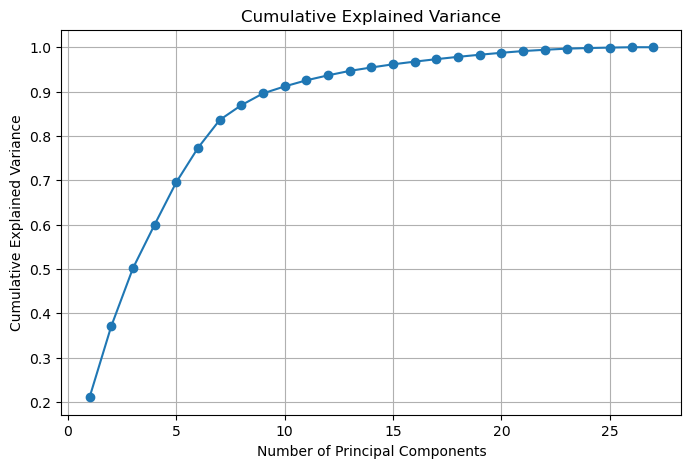

Component 1: 21.10% explained variance
Component 2: 16.01% explained variance
Component 3: 13.06% explained variance
Component 4: 9.83% explained variance
Component 5: 9.56% explained variance
Component 6: 7.74% explained variance
Component 7: 6.29% explained variance
Component 8: 3.34% explained variance
Component 9: 2.65% explained variance
Component 10: 1.58% explained variance
Component 11: 1.38% explained variance
Component 12: 1.12% explained variance
Component 13: 1.00% explained variance
Component 14: 0.77% explained variance
Component 15: 0.71% explained variance
Component 16: 0.60% explained variance
Component 17: 0.56% explained variance
Component 18: 0.52% explained variance
Component 19: 0.47% explained variance
Component 20: 0.44% explained variance
Component 21: 0.39% explained variance
Component 22: 0.28% explained variance
Component 23: 0.25% explained variance
Component 24: 0.14% explained variance
Component 25: 0.10% explained variance
Component 26: 0.08% explained v

In [27]:
# Apply PCA to movies_1a
pca = PCA()
pca_components1 = pca.fit_transform(movies_1a)

# explained variance ratio
explained_variance1 = pca.explained_variance_ratio_

# plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance1) + 1), explained_variance1.cumsum(), marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# print the explained variance for each component
for i, variance in enumerate(explained_variance1, 1):
    print(f"Component {i}: {variance:.2%} explained variance")

In [28]:
# find the number of components needed to explain the 80% of the variance
cumulative_variance1 = np.cumsum(explained_variance1)
n_components = np.argmax(cumulative_variance1 >= 0.80) + 1  
print(f"Number of needed PCAs to explain the 80% of the variance: {n_components}")

Number of needed PCAs to explain the 80% of the variance: 7


#### ***PCA 2) Let's try with movies_1b --> numerical features only (without genres)***

In [29]:
movies_1b = movies_1.drop(['movieId', 'title', 'relevant_genome_tag', 'common_user_tag', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'], axis=1)
movies_1b.head(10)

ratings_avg  (no genres listed)  ratings_count  release_year  genre_count  \
0     1.198467                   0      16.015433      0.118376     2.894060   
1     0.119805                   0       7.035868      0.118376     0.968217   
2     0.027132                   0       3.925795      0.118376     0.005295   
3    -0.413369                   0       0.661659      0.118376     0.968217   
4    -0.104341                   0       3.738040      0.118376    -0.957627   
5     1.067206                   0       7.577546      0.118376     0.968217   
6     0.354783                   0       3.999720      0.118376     0.005295   
7     0.013458                   0       0.223017      0.118376     0.005295   
8    -0.195084                   0       1.055488      0.118376    -0.957627   
9     0.451424                   0       9.247722      0.118376     0.968217   

   years_since_release  relevant_genome_tag_count  common_user_tag_count  
0            -0.239887                  -1.281111              -0.650275  
1            -0.239887                  -1.278789              -0.653467  
2            -0.239887                  -1.279400              -0.657820  
3            -0.239887                  -1.277077              -0.657239  
4            -0.239887                  -1.279400              -0.657820  
5            -0.239887                  -1.279155              -0.650565  
6            -0.239887                  -1.273165              -0.648824  
7            -0.239887                  -1.278789              -0.657529  
8            -0.239887                  -1.267176              -0.653467  
9            -0.239887                  -1.281111              -0.656079

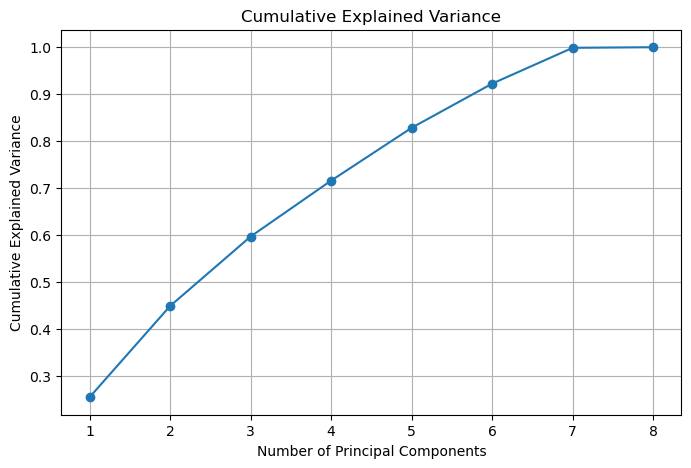

Component 1: 25.50% explained variance
Component 2: 19.41% explained variance
Component 3: 14.79% explained variance
Component 4: 11.90% explained variance
Component 5: 11.25% explained variance
Component 6: 9.40% explained variance
Component 7: 7.62% explained variance
Component 8: 0.12% explained variance


In [30]:
# Apply PCA to movies_1b
pca = PCA()
pca_components2 = pca.fit_transform(movies_1b)

# explained variance ratio
explained_variance2 = pca.explained_variance_ratio_

# plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance2) + 1), explained_variance2.cumsum(), marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# print the explained variance for each component
for i, variance in enumerate(explained_variance2, 1):
    print(f"Component {i}: {variance:.2%} explained variance")

In [31]:
# find the number of components needed to explain the 80% of the variance
cumulative_variance2 = np.cumsum(explained_variance2)
n_components = np.argmax(cumulative_variance2 >= 0.80) + 1 
print(f"Number of needed PCAs to explain the 80% of the variance: {n_components}")

Number of needed PCAs to explain the 80% of the variance: 5


## ***Clustering: with "movies_1a" and then with "movies_1b"***

#### ***CLS 1) Let's try it with movies_1a (with genres)***

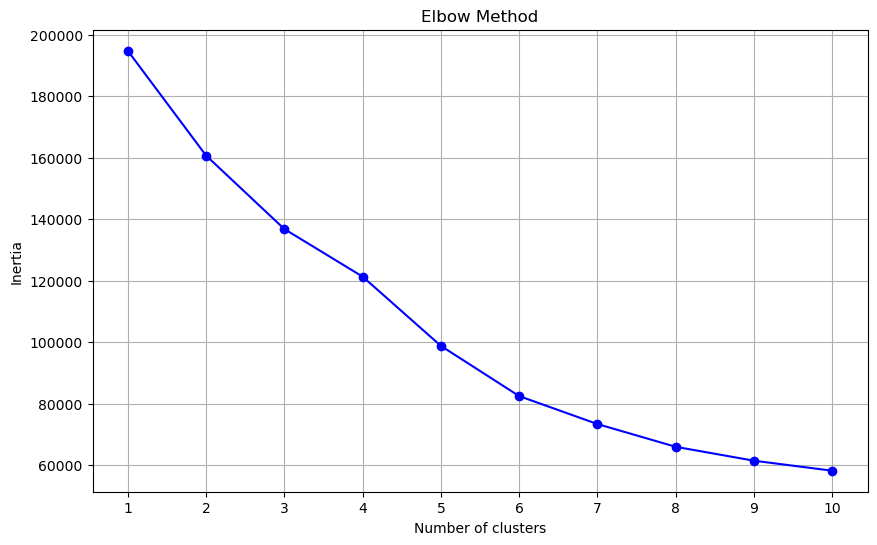

In [32]:
# 1. Elbow Method 
inertia = []
k_values = range(1, 11)

X_pca1 = pca_components1[:, :7]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca1)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

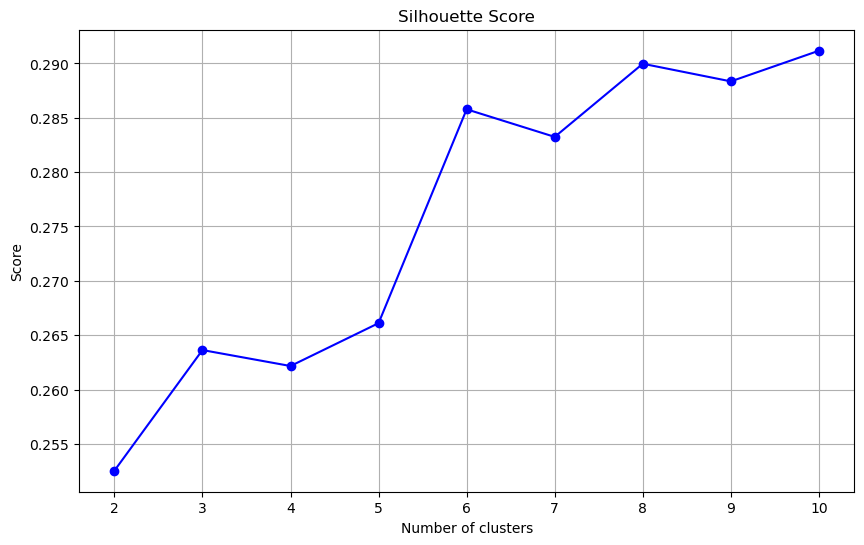

In [33]:
# 2. Silhouette Score

silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels1 = kmeans.fit_predict(X_pca1)
    score1 = silhouette_score(X_pca1, labels1)
    silhouette_scores.append(score1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='b')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.xticks(k_values)
plt.grid()
plt.show()

In [34]:
def map_phase(data, centroids):
    # for each point, find the nearest centroid
    distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
    cluster_assignments = np.argmin(distances, axis=1)
    return cluster_assignments


def reduce_phase(data, cluster_assignments, k):
    # for each cluster, calculate the new centroid
    new_centroids = np.array([
        data[cluster_assignments == i].mean(axis=0) for i in range(k)
    ])
    return new_centroids


def k_means_mapreduce(data, k, max_iters=100, tol=1e-4):
    # Initialize centroids randomly
    np.random.seed(42)
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for i in range(max_iters):
        # Map Phase: assign each point to the nearest centroid
        cluster_assignments = map_phase(data, centroids)

        # Reduce Phase: calculate the new centroids
        new_centroids = reduce_phase(data, cluster_assignments, k)

        # Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return centroids, cluster_assignments

In [35]:
# Clustering with movies_1a
centroids_case1, labels_case1 = k_means_mapreduce(X_pca1, k=5)

unique1, counts1 = np.unique(labels_case1, return_counts=True)
for cluster_id, count in zip(unique1, counts1):
    print(f"Cluster {cluster_id}: {count} points")


Cluster 0: 6554 points
Cluster 1: 3791 points
Cluster 2: 6708 points
Cluster 3: 5712 points
Cluster 4: 4513 points


In [36]:
cluster_means1 = np.array([X_pca1[labels_case1 == i].mean(axis=0) for i in range(5)])

for i, mean in enumerate(cluster_means1):
    print(f"Cluster {i}: {mean}")

Cluster 0: [ 0.21233631 -0.42068662 -0.4844627  -0.39089642  0.15961484 -0.08943559
  0.92535883]
Cluster 1: [-2.01350766 -0.2310252   1.00176835  0.06437375  0.12169965 -0.15610911
 -0.13963553]
Cluster 2: [ 1.4432545  -0.5722919   0.32909539  0.62755805  0.36833213 -0.20910599
 -0.48305727]
Cluster 3: [-1.00994764 -0.13092043 -0.67748353 -0.14209483 -0.76504752 -0.0747491
 -0.49676655]
Cluster 4: [ 0.51607026  1.82134904  0.23037419 -0.23933515  0.08679382  0.66643483
  0.12019393]


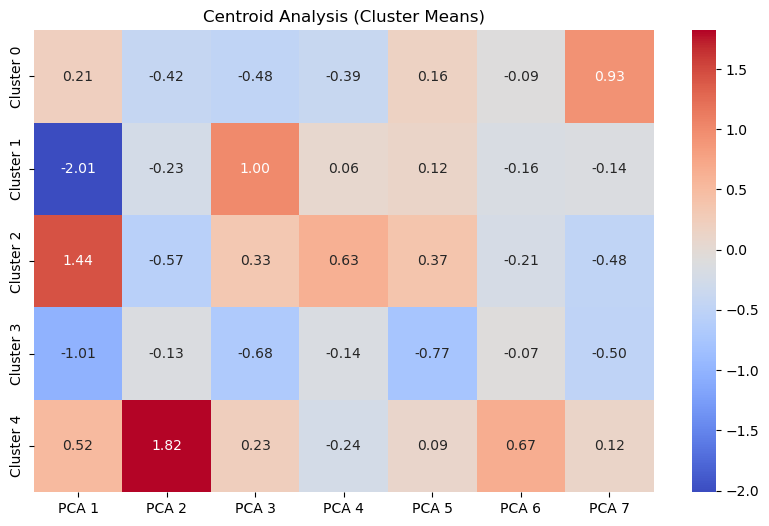

In [37]:
# Datframe of centroids
centroid_df1 = pd.DataFrame({
    'Cluster 0': [0.21233631, -0.42068662, -0.4844627, -0.39089642, 0.15961484, -0.08943559, 0.92535883],
    'Cluster 1': [-2.01350766, -0.2310252, 1.00176835, 0.06437375, 0.12169965, -0.15610911, -0.13963553],
    'Cluster 2': [1.4432545, -0.5722919, 0.32909539, 0.62755805, 0.36833213, -0.20910599, -0.48305727],
    'Cluster 3': [-1.00994764, -0.13092043, -0.67748353, -0.14209483, -0.76504752, -0.0747491, -0.49676655],
    'Cluster 4': [0.51607026, 1.82134904, 0.23037419, -0.23933515, 0.08679382, 0.66643483, 0.12019393]
}).T

centroid_df1.columns = [f"PCA {i+1}" for i in range(centroid_df1.shape[1])]

# Heatmap of centroids
plt.figure(figsize=(10, 6))
sns.heatmap(centroid_df1, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Centroid Analysis (Cluster Means)")
plt.show()

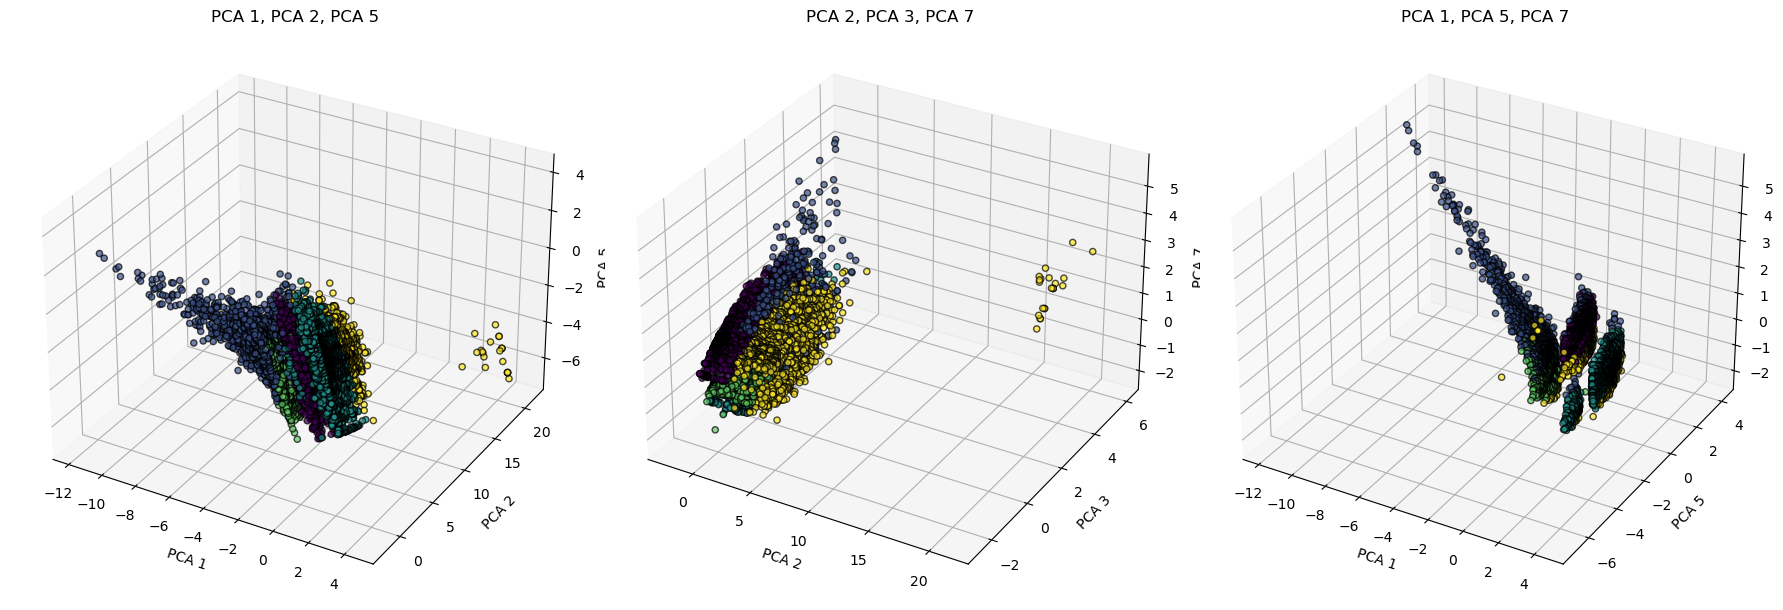

In [38]:
selected_combinations1 = [
    (0, 1, 4),  # PCA 1, PCA 2, PCA 5
    (1, 2, 6),  # PCA 2, PCA 3, PCA 7
    (0, 4, 6)   # PCA 1, PCA 5, PCA 7
]

# plot the clusters
fig = plt.figure(figsize=(18, 6))  

for i, (x_idx, y_idx, z_idx) in enumerate(selected_combinations1):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')  
    
    # Scatter plot
    ax.scatter(
        X_pca1[:, x_idx], X_pca1[:, y_idx], X_pca1[:, z_idx],
        c=labels_case1, cmap='viridis', alpha=0.7, edgecolor='k'
    )
    
    # title and labels
    ax.set_title(f'PCA {x_idx+1}, PCA {y_idx+1}, PCA {z_idx+1}')
    ax.set_xlabel(f'PCA {x_idx+1}')
    ax.set_ylabel(f'PCA {y_idx+1}')
    ax.set_zlabel(f'PCA {z_idx+1}')

# plot
plt.tight_layout()
plt.show()

### ***CLS 2) Let's try it with movies_1b (without genres)***

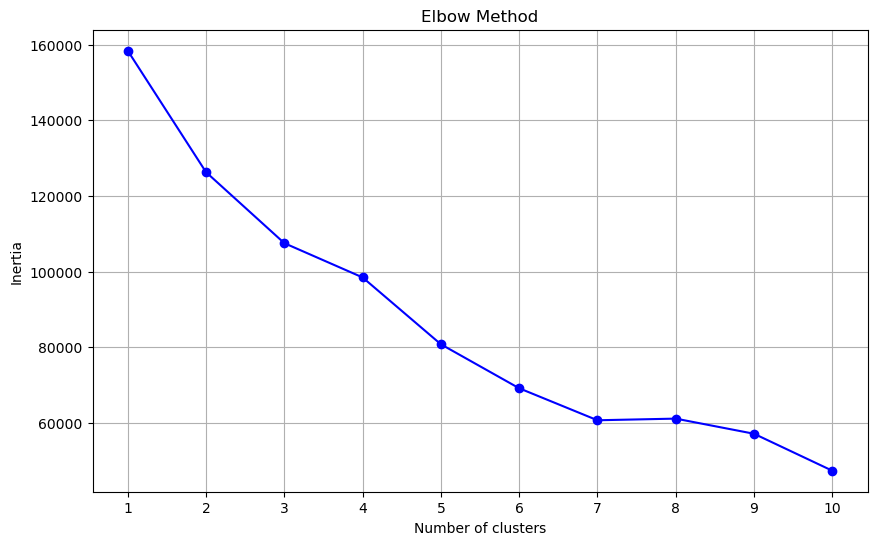

In [39]:
# 1. Elbow Method 
inertia = []
k_values = range(1, 11)

X_pca2 = pca_components2[:, :5]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca2)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

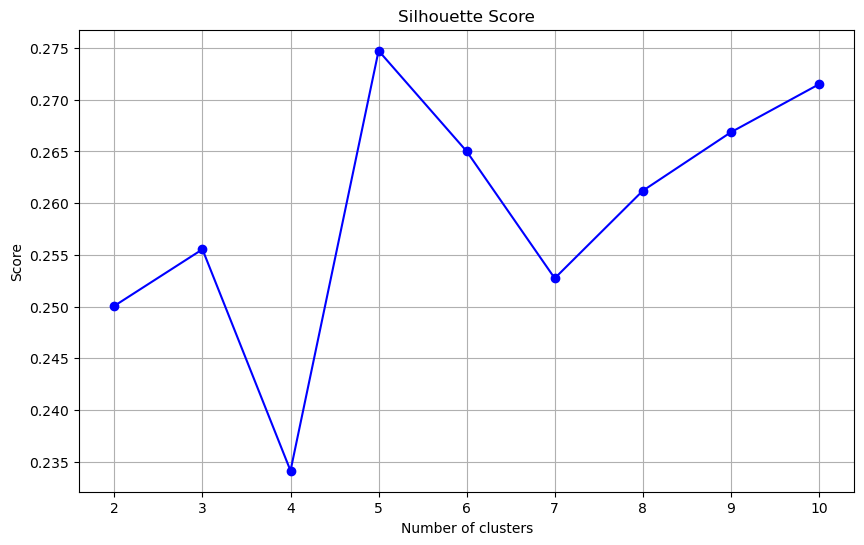

In [40]:
# 2. Silhouette Score

silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels2 = kmeans.fit_predict(X_pca2)
    score2 = silhouette_score(X_pca2, labels2)
    silhouette_scores.append(score2)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='b')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.xticks(k_values)
plt.grid()
plt.show()

In [41]:
# Clustering with movies_1b
centroids_case2, labels_case2 = k_means_mapreduce(X_pca2, k=5)

unique2, counts2 = np.unique(labels_case2, return_counts=True)
for cluster_id, count in zip(unique2, counts2):
    print(f"Cluster {cluster_id}: {count} points")

Cluster 0: 7358 points
Cluster 1: 4014 points
Cluster 2: 5492 points
Cluster 3: 5651 points
Cluster 4: 4763 points


In [42]:
cluster_means2 = np.array([X_pca2[labels_case2 == i].mean(axis=0) for i in range(5)])

for i, mean in enumerate(cluster_means2):
    print(f"Cluster {i}: {mean}")

Cluster 0: [ 0.38774004 -0.40266797 -0.73653303  0.14379349  0.49406348]
Cluster 1: [-1.85150713 -0.21736268  1.02744096 -0.04202387  0.25772416]
Cluster 2: [ 1.5057941  -0.65826487  0.73904322  0.31947837 -0.28804154]
Cluster 3: [-1.05662038 -0.16586028 -0.58734596 -0.29617677 -0.73590239]
Cluster 4: [ 0.47871067  1.76103124  0.11663419 -0.20370122  0.22479208]


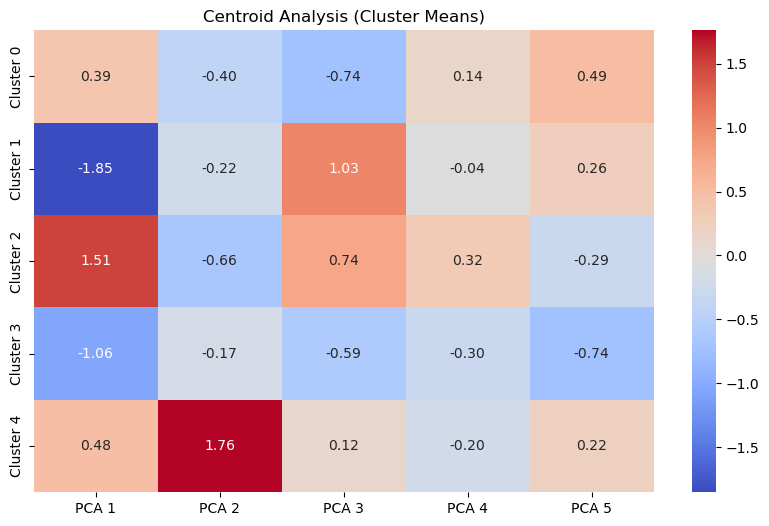

In [43]:
# Datframe of centroids
centroid_df2 = pd.DataFrame({
    'Cluster 0': [0.38774004, -0.40266797, -0.73653303, 0.14379349, 0.49406348],
    'Cluster 1': [-1.85150713, -0.21736268, 1.02744096, -0.04202387, 0.25772416],
    'Cluster 2': [1.5057941, -0.65826487, 0.73904322, 0.31947837, -0.28804154],
    'Cluster 3': [-1.05662038, -0.16586028, -0.58734596, -0.29617677, -0.73590239],
    'Cluster 4': [0.47871067, 1.76103124, 0.11663419, -0.20370122, 0.22479208]
}).T

centroid_df2.columns = [f"PCA {i+1}" for i in range(centroid_df2.shape[1])]

# Heatmap of centroids
plt.figure(figsize=(10, 6))
sns.heatmap(centroid_df2, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Centroid Analysis (Cluster Means)")
plt.show()

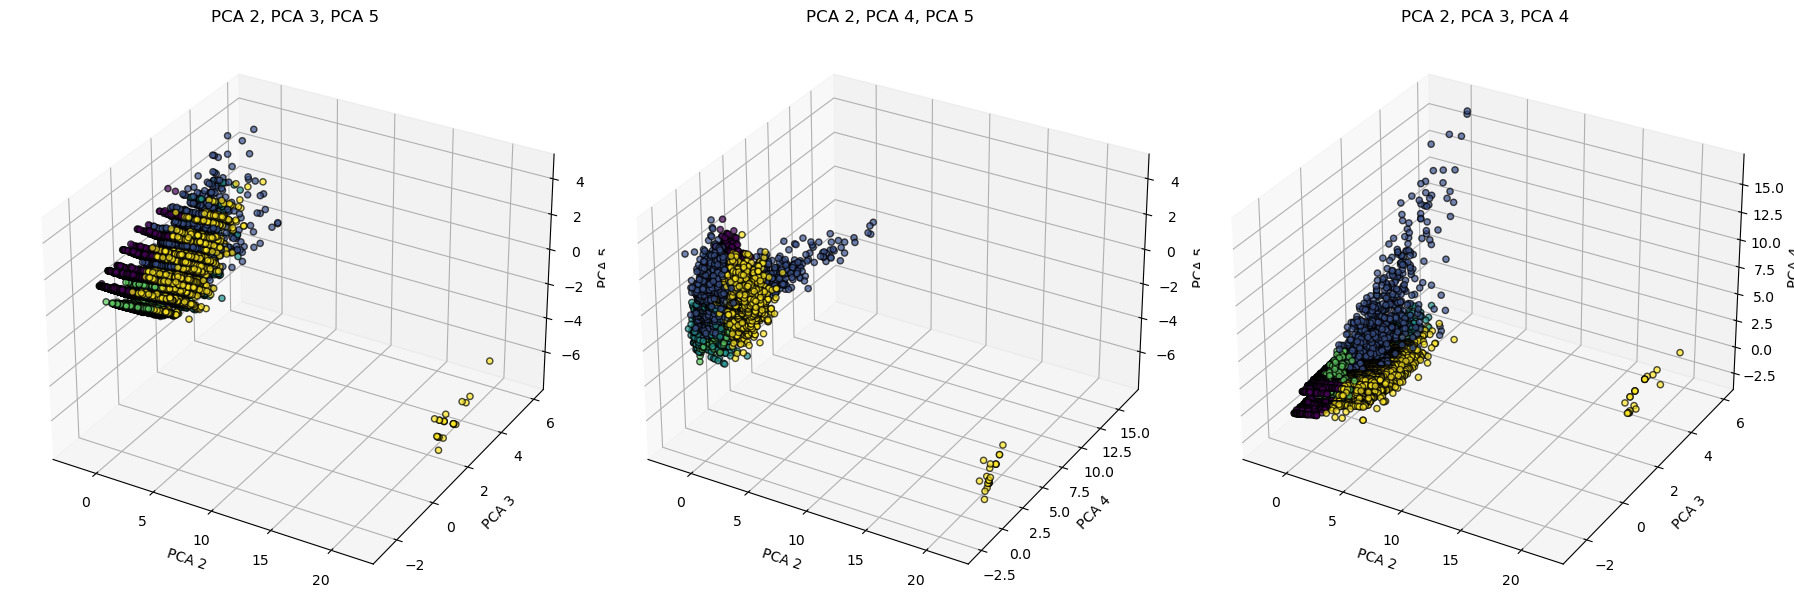

In [44]:
selected_combinations2 = [
    (1, 2, 4),  # PCA 2, PCA 3, PCA 5
    (1, 3, 4),  # PCA 2, PCA 4, PCA 5
    (1, 2, 3)   # PCA 2, PCA 3, PCA 4
]

# Plot the clusters
fig = plt.figure(figsize=(18, 6))  

for i, (x_idx, y_idx, z_idx) in enumerate(selected_combinations2):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')  
    
    # Scatter plot
    ax.scatter(
        X_pca2[:, x_idx], X_pca2[:, y_idx], X_pca2[:, z_idx],
        c=labels_case2, cmap='viridis', alpha=0.7, edgecolor='k'
    )
    
    # title and labels
    ax.set_title(f'PCA {x_idx+1}, PCA {y_idx+1}, PCA {z_idx+1}')
    ax.set_xlabel(f'PCA {x_idx+1}')
    ax.set_ylabel(f'PCA {y_idx+1}')
    ax.set_zlabel(f'PCA {z_idx+1}')

# plot
plt.tight_layout()
plt.show()

### ***PCA 3) PCA with all features standardized (also the genres) --> "movies_1c"***

In [100]:
movies_1c = movies_1.drop(['movieId', 'title', 'relevant_genome_tag', 'common_user_tag'], axis=1)

genre_columns = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Standardize the genre columns
scaler = StandardScaler()
movies_1c[genre_columns] = scaler.fit_transform(movies_1c[genre_columns])

movies_1c.head()


ratings_avg  (no genres listed)    Action  Adventure  Animation  Children  \
0     1.198467                   0 -0.384916   3.272969   5.055775  4.790520   
1     0.119805                   0 -0.384916   3.272969  -0.197794  4.790520   
2     0.027132                   0 -0.384916  -0.305533  -0.197794 -0.208746   
3    -0.413369                   0 -0.384916  -0.305533  -0.197794 -0.208746   
4    -0.104341                   0 -0.384916  -0.305533  -0.197794 -0.208746   

     Comedy     Crime  Documentary     Drama  ...    Sci-Fi  Thriller  \
0  1.502486 -0.347495    -0.315609 -0.978600  ... -0.261265 -0.425283   
1 -0.665564 -0.347495    -0.315609 -0.978600  ... -0.261265 -0.425283   
2  1.502486 -0.347495    -0.315609 -0.978600  ... -0.261265 -0.425283   
3  1.502486 -0.347495    -0.315609  1.021868  ... -0.261265 -0.425283   
4  1.502486 -0.347495    -0.315609 -0.978600  ... -0.261265 -0.425283   

        War  Western  ratings_count  release_year  genre_count  \
0 -0.213951 -0.15941      16.015433      0.118376     2.894060   
1 -0.213951 -0.15941       7.035868      0.118376     0.968217   
2 -0.213951 -0.15941       3.925795      0.118376     0.005295   
3 -0.213951 -0.15941       0.661659      0.118376     0.968217   
4 -0.213951 -0.15941       3.738040      0.118376    -0.957627   

   years_since_release  relevant_genome_tag_count  common_user_tag_count  
0            -0.239887                  -1.281111              -0.650275  
1            -0.239887                  -1.278789              -0.653467  
2            -0.239887                  -1.279400              -0.657820  
3            -0.239887                  -1.277077              -0.657239  
4            -0.239887                  -1.279400              -0.657820  

[5 rows x 27 columns]

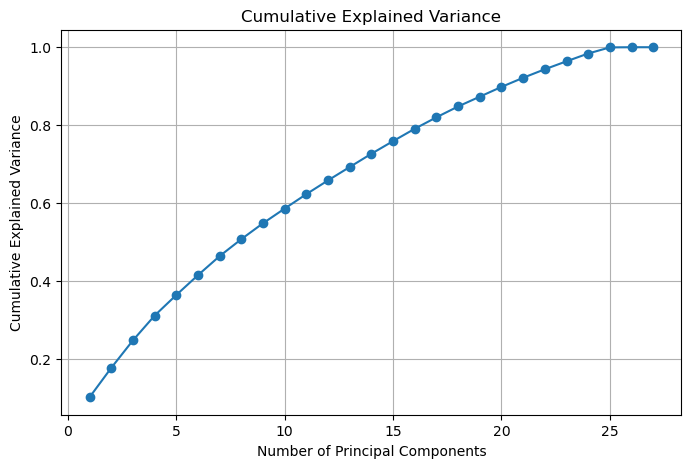

Component 1: 10.15% explained variance
Component 2: 7.54% explained variance
Component 3: 7.06% explained variance
Component 4: 6.36% explained variance
Component 5: 5.29% explained variance
Component 6: 5.09% explained variance
Component 7: 4.89% explained variance
Component 8: 4.35% explained variance
Component 9: 4.08% explained variance
Component 10: 3.77% explained variance
Component 11: 3.71% explained variance
Component 12: 3.54% explained variance
Component 13: 3.43% explained variance
Component 14: 3.40% explained variance
Component 15: 3.24% explained variance
Component 16: 3.17% explained variance
Component 17: 2.94% explained variance
Component 18: 2.78% explained variance
Component 19: 2.51% explained variance
Component 20: 2.51% explained variance
Component 21: 2.34% explained variance
Component 22: 2.19% explained variance
Component 23: 2.05% explained variance
Component 24: 2.00% explained variance
Component 25: 1.57% explained variance
Component 26: 0.04% explained var

In [102]:
# Apply PCA to movies_1c
pca = PCA()
pca_components3 = pca.fit_transform(movies_1c)

# explained variance ratio
explained_variance3 = pca.explained_variance_ratio_

# plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance3) + 1), explained_variance3.cumsum(), marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# print the explained variance for each component
for i, variance in enumerate(explained_variance3, 1):
    print(f"Component {i}: {variance:.2%} explained variance")

In [103]:
# find the number of components needed to explain the 80% of the variance
cumulative_variance3 = np.cumsum(explained_variance3)
n_components = np.argmax(cumulative_variance3 >= 0.80) + 1  # 80%
print(f"Number of needed PCAs to explain the 80% of the variance: {n_components}")

# find the number of components needed to explain the 35% of the variance
n_components = np.argmax(cumulative_variance3 >= 0.35) + 1  # 35%
print(f"Number of needed PCAs to explain the 35% of the variance: {n_components}")

Number of needed PCAs to explain the 80% of the variance: 17
Number of needed PCAs to explain the 35% of the variance: 5


### ***CLS 3) Clustering with all the features standardized (also the genres) --> "movies_1c"***

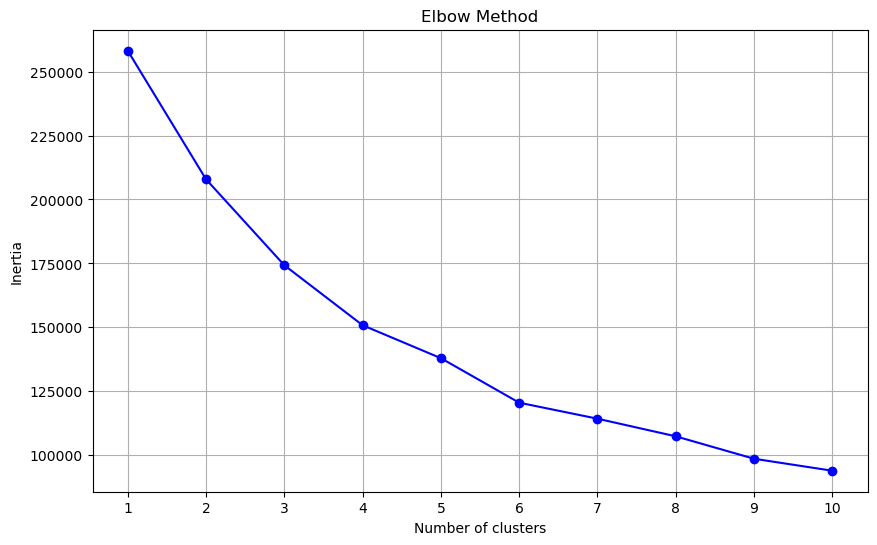

In [104]:
# 1. Elbow Method 
inertia = []
k_values = range(1, 11)

X_pca3 = pca_components3[:, :5]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca3)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

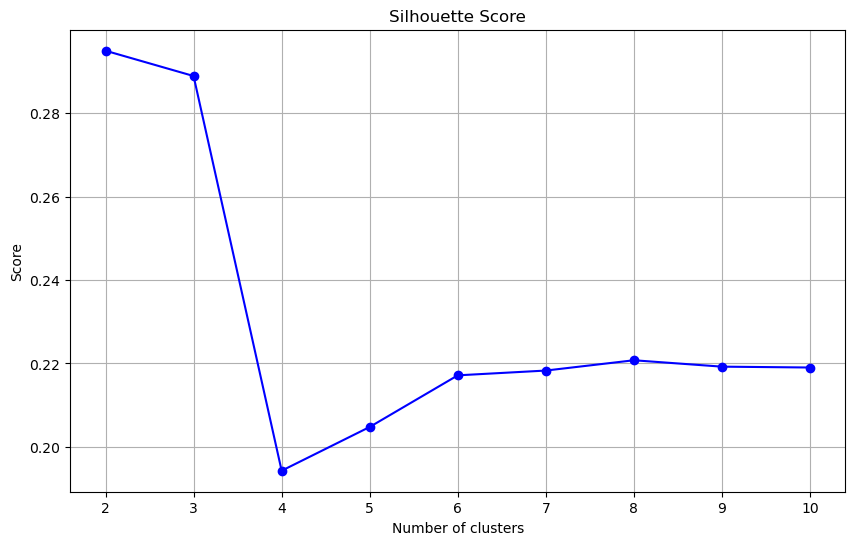

In [105]:
# 2. Silhouette Score

silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels3 = kmeans.fit_predict(X_pca3)
    score3 = silhouette_score(X_pca3, labels3)
    silhouette_scores.append(score3)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='b')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.xticks(k_values)
plt.grid()
plt.show()

In [106]:
# Clustering with movies_1c
centroids_case3, labels_case3 = k_means_mapreduce(X_pca3, k=3)

unique3, counts3 = np.unique(labels_case3, return_counts=True)
for cluster_id, count in zip(unique3, counts3):
    print(f"Cluster {cluster_id}: {count} points")

Cluster 0: 5202 points
Cluster 1: 2690 points
Cluster 2: 19386 points


In [107]:
cluster_means3 = np.array([X_pca3[labels_case3 == i].mean(axis=0) for i in range(3)])

for i, mean in enumerate(cluster_means3):
    print(f"Cluster {i}: {mean}")

Cluster 0: [ 1.42891513  1.88502273 -0.67480632 -0.05121242  0.25706725]
Cluster 1: [ 2.98942747 -2.10491877 -0.15973065  0.32025768 -0.79408684]
Cluster 2: [-0.79824494 -0.2137448   0.20324037 -0.03069669  0.04120653]


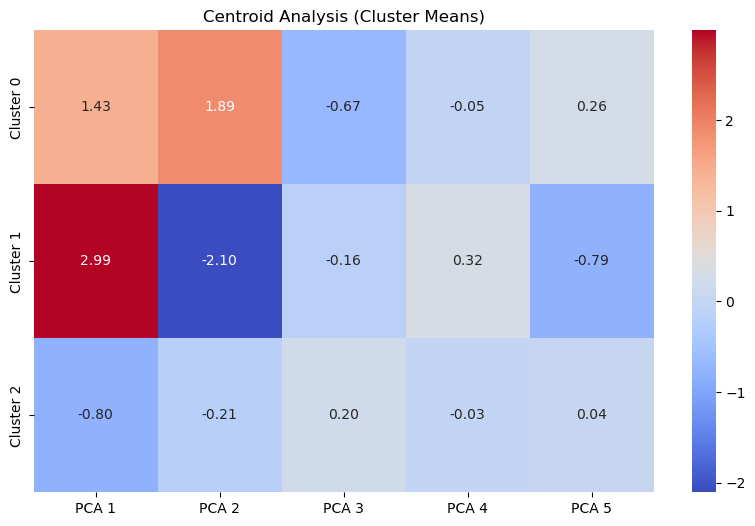

In [108]:
# Datframe of centroids
centroid_df3 = pd.DataFrame({
    'Cluster 0': [ 1.42891513, 1.88502273, -0.67480632, -0.05121242, 0.25706725],
    'Cluster 1': [ 2.98942747, -2.10491877, -0.15973065, 0.32025768, -0.79408684],
    'Cluster 2': [-0.79824494, -0.2137448, 0.20324037, -0.03069669, 0.04120653],
}).T

centroid_df3.columns = [f"PCA {i+1}" for i in range(centroid_df3.shape[1])]

# Heatmap of centroids
plt.figure(figsize=(10, 6))
sns.heatmap(centroid_df3, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Centroid Analysis (Cluster Means)")
plt.show()

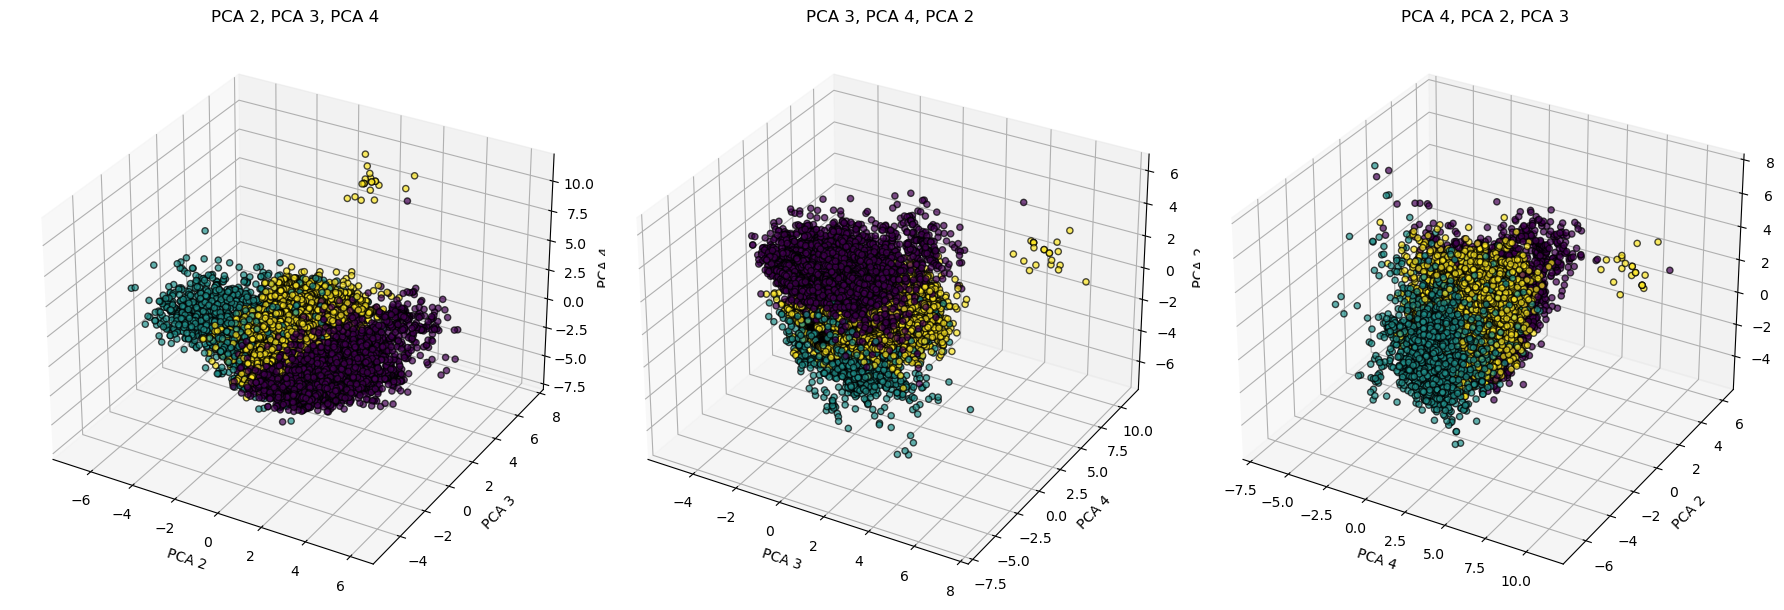

In [109]:
selected_combinations3 = [
    (1, 2, 3),  # PCA 2, PCA 3, PCA 4
    (2, 3, 1),  # PCA 3, PCA 4, PCA 2
    (3, 1, 2)   # PCA 4, PCA 2, PCA 3
]

# plot the clusters
fig = plt.figure(figsize=(18, 6))  

for i, (x_idx, y_idx, z_idx) in enumerate(selected_combinations3):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d') 
    
    # Scatter plot
    ax.scatter(
        X_pca3[:, x_idx], X_pca3[:, y_idx], X_pca3[:, z_idx],
        c=labels_case3, cmap='viridis', alpha=0.7, edgecolor='k'
    )
    
    # title and labels
    ax.set_title(f'PCA {x_idx+1}, PCA {y_idx+1}, PCA {z_idx+1}')
    ax.set_xlabel(f'PCA {x_idx+1}')
    ax.set_ylabel(f'PCA {y_idx+1}')
    ax.set_zlabel(f'PCA {z_idx+1}')

# plot
plt.tight_layout()
plt.show()

## ***Report Test A***

### ***movies_1a***

The movies_1a dataset is characterized by standardized numerical variables and one-hot encoded genres, but the genres were not standardized. The inclusion of non-standardized genres may introduce slight discrepancies in PCA and clustering analyses, as these variables are not treated numerically in the same way as the others. PCA (Principal Component Analysis) was applied to reduce the dataset's dimensionality while preserving as much variance as possible. The PCA reduced the dataset to 27 principal components, with the first 10 components explaining a cumulative variance of approximately 91.6%:

- Component 1: 21.10%
- Component 2: 16.01%
- Component 3: 13.06%
- Component 4: 9.83%

The remaining components explain decreasing levels of variance, down to less than 0.1% for the 25th component.
Dimensionality reduction is effective with a small number of components. For instance, selecting the first 7 components retains about 77% of the total variance, which is useful for simpler visualizations such as 3D plots. After dimensionality reduction, clustering was performed using K-means and K-means++. The Elbow Method plot shows a significant reduction in inertia up to k=5, suggesting that 5 clusters are optimal for this dataset. The silhouette scores for clustering are:

- K-means: 0.2617
- K-means++: 0.2569 Although the scores are relatively low, they are consistent with the complexity of high-dimensional data and the presence of overlapping clusters.

The resulting clusters contain:

- Cluster 0: 480 points
- Cluster 1: 13,136 points
- Cluster 2: 5,334 points
- Cluster 3: 5,512 points
- Cluster 4: 2,816 points

The uneven distribution suggests that some data configurations are more predominant than others. The centroids reveal significant differences between clusters, particularly in the first PCA components. For example:

- Cluster 4 is characterized by high values in PCA 2.
- Cluster 1 has a strong positive correlation with PCA 3.

### ***movies_1b***

The movies_1b dataset consists exclusively of standardized numerical features, ensuring uniform treatment across all variables. The exclusion of genres (present in movies_1a) allows for a focus on numerical characteristics, reducing the impact of non-standardized categorical features. PCA was applied to reduce the dataset's dimensionality. The cumulative variance plot shows that the first 5 principal components explain about 80% of the total variance, with:

- Component 1: 25.50%
- Component 2: 19.41%
- Component 3: 14.79%
- Component 4: 11.90%
- Component 5: 11.25%

With only 5 principal components, it is possible to adequately represent most of the variance, suggesting redundancy in the original numerical features. Dimensionality reduction was particularly effective due to the uniform standardization of variables. Clustering (K-means and K-means++) was then applied using the first 5 PCA components. The Elbow Method plot suggests an optimal number of clusters at k=5, given the slowdown in inertia reduction beyond this threshold. The silhouette scores for clustering are:

- K-means: 0.2279
- K-means++: 0.2453 

Although the scores are lower compared to the movies_1a dataset, they are still acceptable for standardized numerical data in high dimensions.
The resulting clusters show uneven distribution:

- Cluster 0: 5,597 points
- Cluster 1: 8,866 points
- Cluster 2: 7,420 points
- Cluster 3: 452 points
- Cluster 4: 4,943 points

This distribution highlights a significant concentration in clusters 1 and 2, while cluster 3 represents a very small number of data points, possibly indicating a niche or outliers. The centroids analysis reveals unique characteristics among clusters:

- Cluster 1: Shows a high positive correlation with PCA 3.
- Cluster 2: Stands out for high values in PCA 1 and PCA 5.
- Cluster 4: Exhibits a high value in PCA 2, suggesting that this component significantly contributes to segmentation.

The exclusion of genres simplified the analysis and improved the interpretability of principal components.


### ***movies_1c***

The movies_1c dataset combines numerical features and genres, both standardized. This ensures equal scaling among all variables, reducing the risk that certain features disproportionately influence PCA and clustering. The decision to standardize everything makes this dataset particularly suitable for analyses based on distance measures (such as K-means). The goal of PCA on movies_1c is to reduce dimensionality while preserving most of the variance. With 27 principal components, the original dataset was reduced without significant loss of information:

- Component 1 explains 10.15% of the variance.
- The first 17 components explain 80% of the total variance.
- Only 5 components are needed to explain 35% of the variance (we'll use this decision for simplified analysis, including graphical representations).

After dimensionality reduction, clustering (K-means and K-means++) was performed using the principal components. The Elbow Method plot suggests that the optimal number of clusters is k=3, given the significant slowdown in inertia reduction. Silhouette scores are:

- K-means: 0.2888
- K-means++: 0.1578 Although the scores are moderate, they indicate slight separation among clusters, justified by the data's complexity.

The resulting clusters have a relatively balanced distribution:

- Cluster 0: 10,470 points
- Cluster 1: 10,667 points
- Cluster 2: 6,141 points

The balanced distribution (especially between Cluster 0 and 1) suggests that the data is not highly skewed. Centroids analysis shows that:

- Cluster 1 stands out for significantly high values in PCA 1 and negative values in PCA 2.
- Cluster 2 has low values for almost all principal components, suggesting a more "homogeneous" or average nature.

The decision to standardize all variables (numerical and genres) improved the quality of PCA and clustering, resulting in more balanced and representative outcomes.





### ***B) TEST: Trying PCA and then the Clustering without Tag Counts Features ("relevant_genome_tag_count" and "common_user_tag_count")***

In [110]:
movies_1d = movies_1c.copy()
movies_1d = movies_1d.drop(['relevant_genome_tag_count', 'common_user_tag_count'], axis=1)
movies_1d.head()

ratings_avg  (no genres listed)    Action  Adventure  Animation  Children  \
0     1.198467                   0 -0.384916   3.272969   5.055775  4.790520   
1     0.119805                   0 -0.384916   3.272969  -0.197794  4.790520   
2     0.027132                   0 -0.384916  -0.305533  -0.197794 -0.208746   
3    -0.413369                   0 -0.384916  -0.305533  -0.197794 -0.208746   
4    -0.104341                   0 -0.384916  -0.305533  -0.197794 -0.208746   

     Comedy     Crime  Documentary     Drama  ...   Mystery   Romance  \
0  1.502486 -0.347495    -0.315609 -0.978600  ... -0.242413 -0.422214   
1 -0.665564 -0.347495    -0.315609 -0.978600  ... -0.242413 -0.422214   
2  1.502486 -0.347495    -0.315609 -0.978600  ... -0.242413  2.368469   
3  1.502486 -0.347495    -0.315609  1.021868  ... -0.242413  2.368469   
4  1.502486 -0.347495    -0.315609 -0.978600  ... -0.242413 -0.422214   

     Sci-Fi  Thriller       War  Western  ratings_count  release_year  \
0 -0.261265 -0.425283 -0.213951 -0.15941      16.015433      0.118376   
1 -0.261265 -0.425283 -0.213951 -0.15941       7.035868      0.118376   
2 -0.261265 -0.425283 -0.213951 -0.15941       3.925795      0.118376   
3 -0.261265 -0.425283 -0.213951 -0.15941       0.661659      0.118376   
4 -0.261265 -0.425283 -0.213951 -0.15941       3.738040      0.118376   

   genre_count  years_since_release  
0     2.894060            -0.239887  
1     0.968217            -0.239887  
2     0.005295            -0.239887  
3     0.968217            -0.239887  
4    -0.957627            -0.239887  

[5 rows x 25 columns]

### ***PCA 4) with "movies_1d" (without Tag Counts Features)*** 

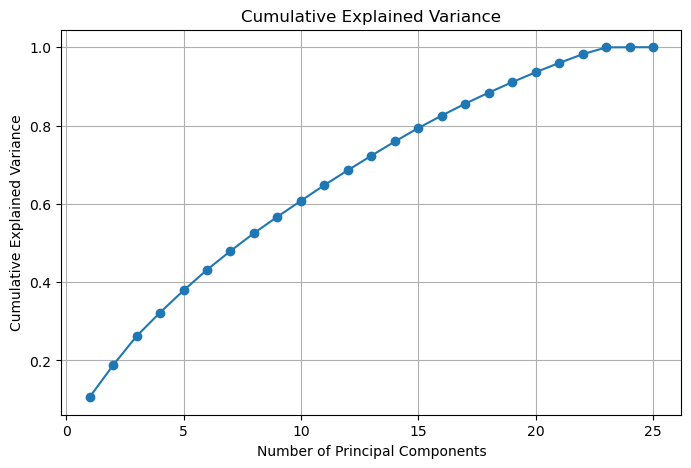

Component 1: 10.60% explained variance
Component 2: 8.17% explained variance
Component 3: 7.43% explained variance
Component 4: 6.04% explained variance
Component 5: 5.63% explained variance
Component 6: 5.29% explained variance
Component 7: 4.81% explained variance
Component 8: 4.55% explained variance
Component 9: 4.20% explained variance
Component 10: 4.06% explained variance
Component 11: 4.01% explained variance
Component 12: 3.80% explained variance
Component 13: 3.70% explained variance
Component 14: 3.63% explained variance
Component 15: 3.44% explained variance
Component 16: 3.19% explained variance
Component 17: 3.05% explained variance
Component 18: 2.80% explained variance
Component 19: 2.68% explained variance
Component 20: 2.54% explained variance
Component 21: 2.37% explained variance
Component 22: 2.23% explained variance
Component 23: 1.73% explained variance
Component 24: 0.05% explained variance
Component 25: 0.00% explained variance


In [111]:
# Apply PCA to movies_1d
pca = PCA()
pca_components4 = pca.fit_transform(movies_1d)

# explained variance ratio
explained_variance4 = pca.explained_variance_ratio_

# plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance4) + 1), explained_variance4.cumsum(), marker='o')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid()
plt.show()

# print the explained variance for each component
for i, variance in enumerate(explained_variance4, 1):
    print(f"Component {i}: {variance:.2%} explained variance")

In [112]:
# find the number of components needed to explain the 80% of the variance
cumulative_variance4 = np.cumsum(explained_variance4)
n_components = np.argmax(cumulative_variance4 >= 0.80) + 1  # 80%
print(f"Number of needed PCAs to explain the 80% of the variance: {n_components}")

# find the number of components needed to explain the 35% of the variance
n_components = np.argmax(cumulative_variance4 >= 0.35) + 1  # 35%
print(f"Number of needed PCAs to explain the 35% of the variance: {n_components}")

Number of needed PCAs to explain the 80% of the variance: 16
Number of needed PCAs to explain the 35% of the variance: 5


### ***CLS 4) Clustering with no Tag Counts Features***

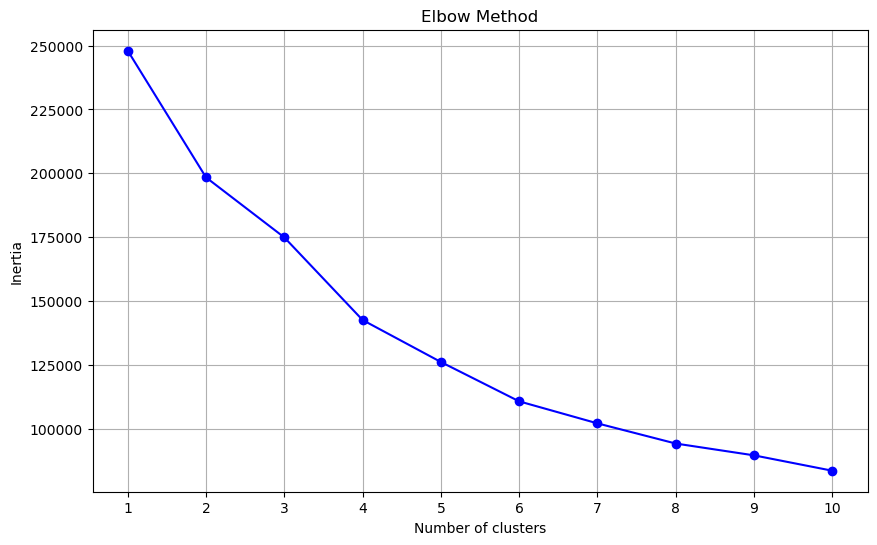

In [113]:
# 1. Elbow Method 
inertia = []
k_values = range(1, 11)

X_pca4 = pca_components4[:, :5]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca4)
    inertia.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid()
plt.show()

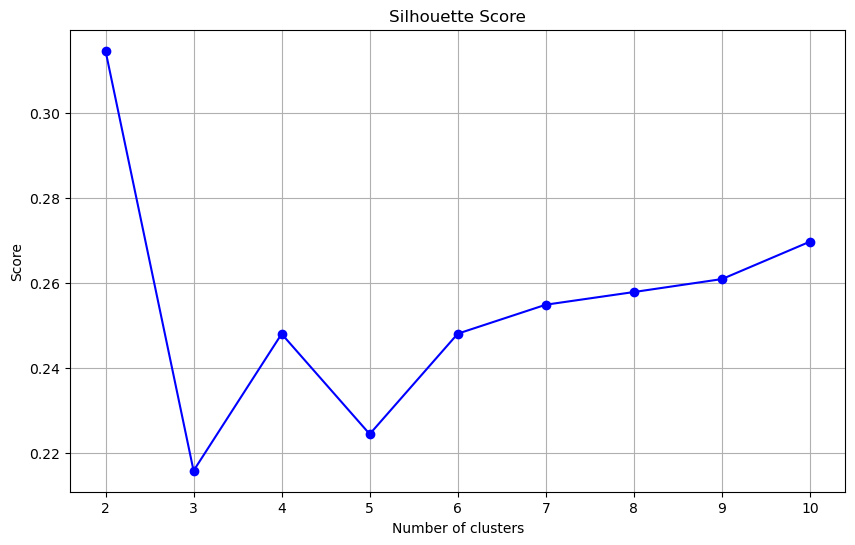

In [114]:
# 2. Silhouette Score

silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels4 = kmeans.fit_predict(X_pca4)
    score4 = silhouette_score(X_pca4, labels4)
    silhouette_scores.append(score4)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, marker='o', color='b')
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.xticks(k_values)
plt.grid()
plt.show()

In [115]:
# Clustering with movies_1d
centroids_case4, labels_case4 = k_means_mapreduce(X_pca4, k=2)

unique4, counts4 = np.unique(labels_case4, return_counts=True)
for cluster_id, count in zip(unique4, counts4):
    print(f"Cluster {cluster_id}: {count} points")

Cluster 0: 19900 points
Cluster 1: 7378 points


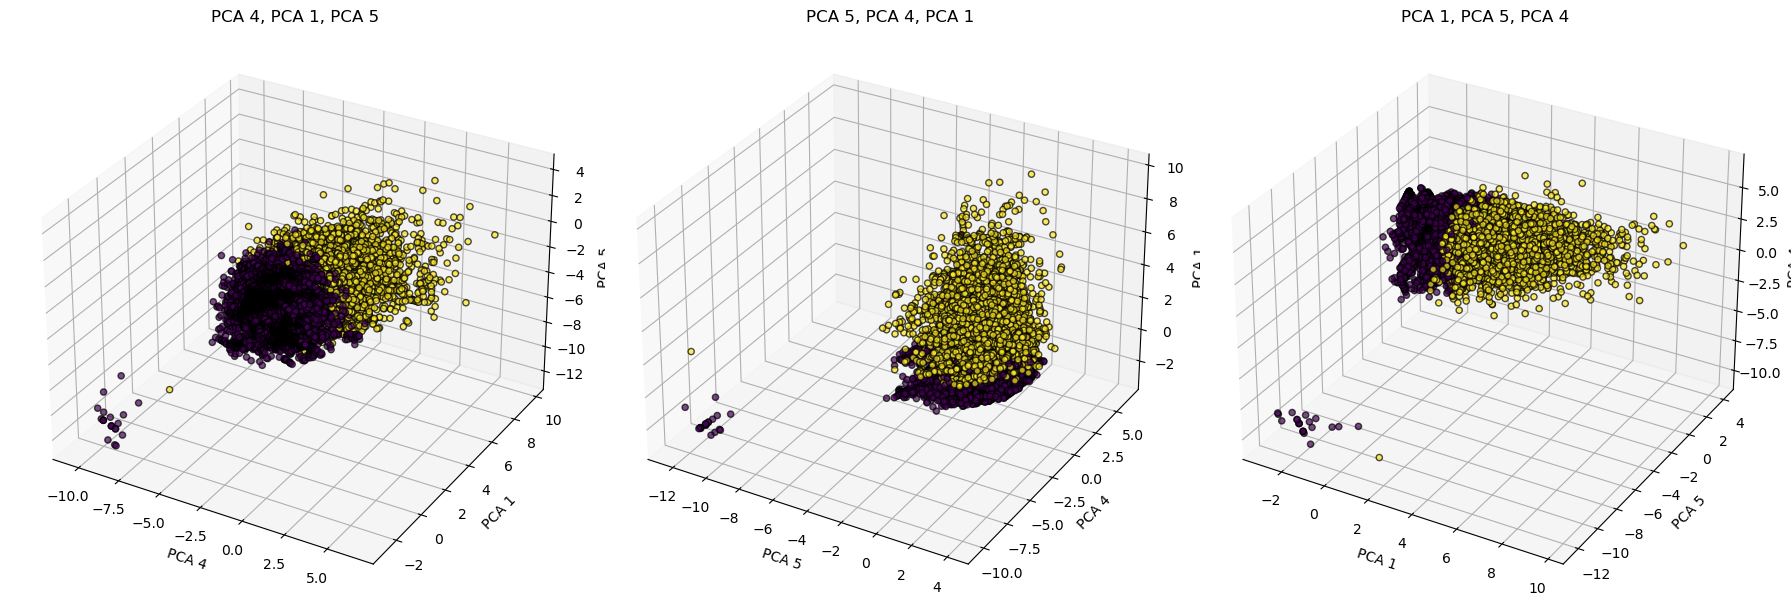

In [116]:
selected_combinations4 = [
    (3, 0, 4),  # PCA 4, PCA 1, PCA 5
    (4, 3, 0),  # PCA 5, PCA 4, PCA 1
    (0, 4, 3)   # PCA 1, PCA 5, PCA 4
]

# plot the clusters
fig = plt.figure(figsize=(18, 6))  

for i, (x_idx, y_idx, z_idx) in enumerate(selected_combinations4):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')  
    
    # Scatter plot
    ax.scatter(
        X_pca4[:, x_idx], X_pca4[:, y_idx], X_pca4[:, z_idx],
        c=labels_case4, cmap='viridis', alpha=0.7, edgecolor='k'
    )
    
    # title and labels
    ax.set_title(f'PCA {x_idx+1}, PCA {y_idx+1}, PCA {z_idx+1}')
    ax.set_xlabel(f'PCA {x_idx+1}')
    ax.set_ylabel(f'PCA {y_idx+1}')
    ax.set_zlabel(f'PCA {z_idx+1}')

# plot
plt.tight_layout()
plt.show()

## ***Report Test B***

### ***movies_1d***

PCA was used to reduce the dimensionality of the dataset while preserving most of the variance.
To explain 80% of the variance, 16 principal components are required.
To explain 35% of the variance, only 5 principal components are sufficient.
The Elbow Method was used to identify the optimal number of clusters. The inertia graph shows a progressive decrease as the number of clusters increases. There is no sharply defined "elbow," but 2 clusters represent a good choice for simplicity of interpretation.
The silhouette score was calculated to evaluate the quality of the clustering. With 2 clusters, the silhouette score is 0.3145, which is a moderate value, indicating decent separation between clusters.

The clustering identified 2 main clusters:

- Cluster 0: 19,900 points.
- Cluster 1: 7,378 points.

The balance between the clusters is acceptable, although Cluster 0 is significantly larger.


# ***Clustering with KMeans++***

In [117]:
def initialize_centroids_kmeans_plus_plus(X, k):
    """
    Inizialize centroids using K-means++
    """
    n_samples, _ = X.shape
    centroids = []

    # Choose the first centroid randomly
    centroids.append(X[np.random.randint(n_samples)])
    
    for _ in range(1, k):
        # Calculate the distance of each point from choosen centroids
        distances = np.array([min(np.linalg.norm(x - c)**2 for c in centroids) for x in X])
        probabilities = distances / distances.sum()
        
        # Choose another centroid based on the probabilities
        cumulative_probs = np.cumsum(probabilities)
        random_value = np.random.rand()
        next_centroid = X[np.searchsorted(cumulative_probs, random_value)]
        centroids.append(next_centroid)
    
    return np.array(centroids)

def k_means_plus_plus(X, k, max_iters=100, tol=1e-4):
    """
    K-means with initialization K-means++
    """
    # Step 1: initialization of centroids with K-means++
    centroids = initialize_centroids_kmeans_plus_plus(X, k)

    for _ in range(max_iters):
        # Step 2: Assign each point to the closest centroid
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)
        
        # Step 3: Calculate the new centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Convergence check
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids

    return centroids, labels


In [118]:
# for movies_1a 
centroids1, labels1 = k_means_plus_plus(X_pca1, k=5)

unique1a, counts1a = np.unique(labels1, return_counts=True)
for cluster_id, count in zip(unique1a, counts1a):
    print(f"Cluster {cluster_id}: {count} points")


Cluster 0: 480 points
Cluster 1: 13136 points
Cluster 2: 5334 points
Cluster 3: 5512 points
Cluster 4: 2816 points


In [119]:
silhouette_kmeans = silhouette_score(X_pca1, labels_case1)
silhouette_kmeans_pp = silhouette_score(X_pca1, labels1)

print(f"Silhouette Score (K-means): {silhouette_kmeans:.4f}")
print(f"Silhouette Score (K-means++): {silhouette_kmeans_pp:.4f}")

Silhouette Score (K-means): 0.2617
Silhouette Score (K-means++): 0.2569


In [120]:
# for movies_1b 
centroids2, labels2 = k_means_plus_plus(X_pca2, k=5)

unique1b, counts1b = np.unique(labels2, return_counts=True)
for cluster_id, count in zip(unique1b, counts1b):
    print(f"Cluster {cluster_id}: {count} points")

Cluster 0: 5597 points
Cluster 1: 8866 points
Cluster 2: 7420 points
Cluster 3: 452 points
Cluster 4: 4943 points


In [121]:
silhouette_kmeans = silhouette_score(X_pca2, labels_case2)
silhouette_kmeans_pp = silhouette_score(X_pca2, labels2)

print(f"Silhouette Score (K-means): {silhouette_kmeans:.4f}")
print(f"Silhouette Score (K-means++): {silhouette_kmeans_pp:.4f}")

Silhouette Score (K-means): 0.2279
Silhouette Score (K-means++): 0.2453


In [122]:
# for movies_1c 
centroids3, labels3 = k_means_plus_plus(X_pca3, k=3)

unique1c, counts1c = np.unique(labels3, return_counts=True)
for cluster_id, count in zip(unique1c, counts1c):
    print(f"Cluster {cluster_id}: {count} points")

Cluster 0: 10470 points
Cluster 1: 10667 points
Cluster 2: 6141 points


In [123]:
silhouette_kmeans = silhouette_score(X_pca3, labels_case3)
silhouette_kmeans_pp = silhouette_score(X_pca3, labels3)

print(f"Silhouette Score (K-means): {silhouette_kmeans:.4f}")
print(f"Silhouette Score (K-means++): {silhouette_kmeans_pp:.4f}")

Silhouette Score (K-means): 0.2888
Silhouette Score (K-means++): 0.1578


In [124]:
# for movies_1d 
centroids4, labels4 = k_means_plus_plus(X_pca4, k=2)

unique1d, counts1d = np.unique(labels4, return_counts=True)
for cluster_id, count in zip(unique1d, counts1d):
    print(f"Cluster {cluster_id}: {count} points")

Cluster 0: 19900 points
Cluster 1: 7378 points


In [125]:
silhouette_kmeans = silhouette_score(X_pca4, labels_case4)
silhouette_kmeans_pp = silhouette_score(X_pca4, labels4)

print(f"Silhouette Score (K-means): {silhouette_kmeans:.4f}")
print(f"Silhouette Score (K-means++): {silhouette_kmeans_pp:.4f}")

Silhouette Score (K-means): 0.3145
Silhouette Score (K-means++): 0.3145


# ***Clustering Algorithm Recommendation from ChatGPT 4o***

#### **DBSCAN** is a density-based clustering algorithm. Unlike K-means, it does not require you to specify the number of clusters K in advance and can identify clusters of arbitrary shape, distinguishing between "Core", "Border" and "Noise" points.

- "Core Points" = A point is considered "Core" if at least `minPTS` other points are within a distance `ε`

- "Border Points" = A point is on board if it is not `Core` but is found within `ε`  from a `Core` point

- "Noise Points" = A point that is neither `Core` nor "Border" is considered `Noise`

- The algorithm starts from a core point and expands the cluster to include all the points that can be reached through core points

### We applied the DBSCAN Algorithm to all the datasets we created above and we decided to take only the third one ("movies_1c")

#### This is what we did for each case:

***We did a sistematic search to find the best Silhouette Score with different combinations between eps = [0.3,0.5,0.7] and min_samples = [3,5,10]***

In [126]:
# test for different values of eps and min_samples
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [3, 5, 10]

best_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca3)
        
        # Ignore if
        if len(set(labels)) > 1:
            score = silhouette_score(X_pca3[labels != -1], labels[labels != -1])
            print(f"eps: {eps}, min_samples: {min_samples}, silhouette: {score:.4f}")
            
            # Update the best parameters
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print("Best Parameters:", best_params)
print("Best Silhouette Score", best_score)

eps: 0.3, min_samples: 3, silhouette: 0.1193
eps: 0.3, min_samples: 5, silhouette: 0.1698
eps: 0.3, min_samples: 10, silhouette: 0.3055
eps: 0.5, min_samples: 3, silhouette: -0.2309
eps: 0.5, min_samples: 5, silhouette: -0.2027
eps: 0.5, min_samples: 10, silhouette: -0.0947
eps: 0.7, min_samples: 3, silhouette: -0.3345
eps: 0.7, min_samples: 5, silhouette: -0.3070
eps: 0.7, min_samples: 10, silhouette: -0.1948
Best Parameters: {'eps': 0.3, 'min_samples': 10}
Best Silhouette Score 0.3054589853096972


***Then, we applied the DBSCAN with eps = 0.3 and min_score = 10***

In [127]:
# Apply DBSCAN to movies_1c
dbscan3 = DBSCAN(eps=0.3, min_samples=10)
labels_dbscan3 = dbscan3.fit_predict(X_pca3)

# Identify the number noise points
num_noise3 = np.sum(labels_dbscan3 == -1)
print(f"Noise Points identified: {num_noise3}")

# Silhouette Score
if len(set(labels_dbscan3)) > 1:  # Silhouette Score not defined for 1 cluster
    silhouette_dbscan3 = silhouette_score(X_pca3[labels_dbscan3 != -1], labels_dbscan3[labels_dbscan3 != -1])
    print(f"Silhouette Score (DBSCAN): {silhouette_dbscan3:.4f}")
else:
    print("Silhouette Score not calculable (only 1 cluster)")

Noise Points identified: 11184
Silhouette Score (DBSCAN): 0.3055


***Let's analyse results:***
 - Noise Points = 11.184 --> this suggests that many points have been excluded from clusters, which may not be ideal if the excluded points are not really outliers
 - Silhouette Score = 0.3055 --> this is the best we could find. It indicates more defined and well-separated clusters

***(NB: with movies_1d we had Silhouette Score = 0.2182 and Noise Points = 8.352 --> this could have been a better result if we were searching for a more balanced compromise --> but we choose differentely just for convenience)***

In [128]:
silhouette_kmeans_pp = silhouette_score(X_pca3, labels3)
print(f"Silhouette Score (K-means++): {silhouette_kmeans_pp:.4f}")
print(f"Silhouette Score (DBSCAN): {silhouette_dbscan3:.4f}")

Silhouette Score (K-means++): 0.1578
Silhouette Score (DBSCAN): 0.3055


***As we can see, the Silhouette Score is better with the DBSCAN***

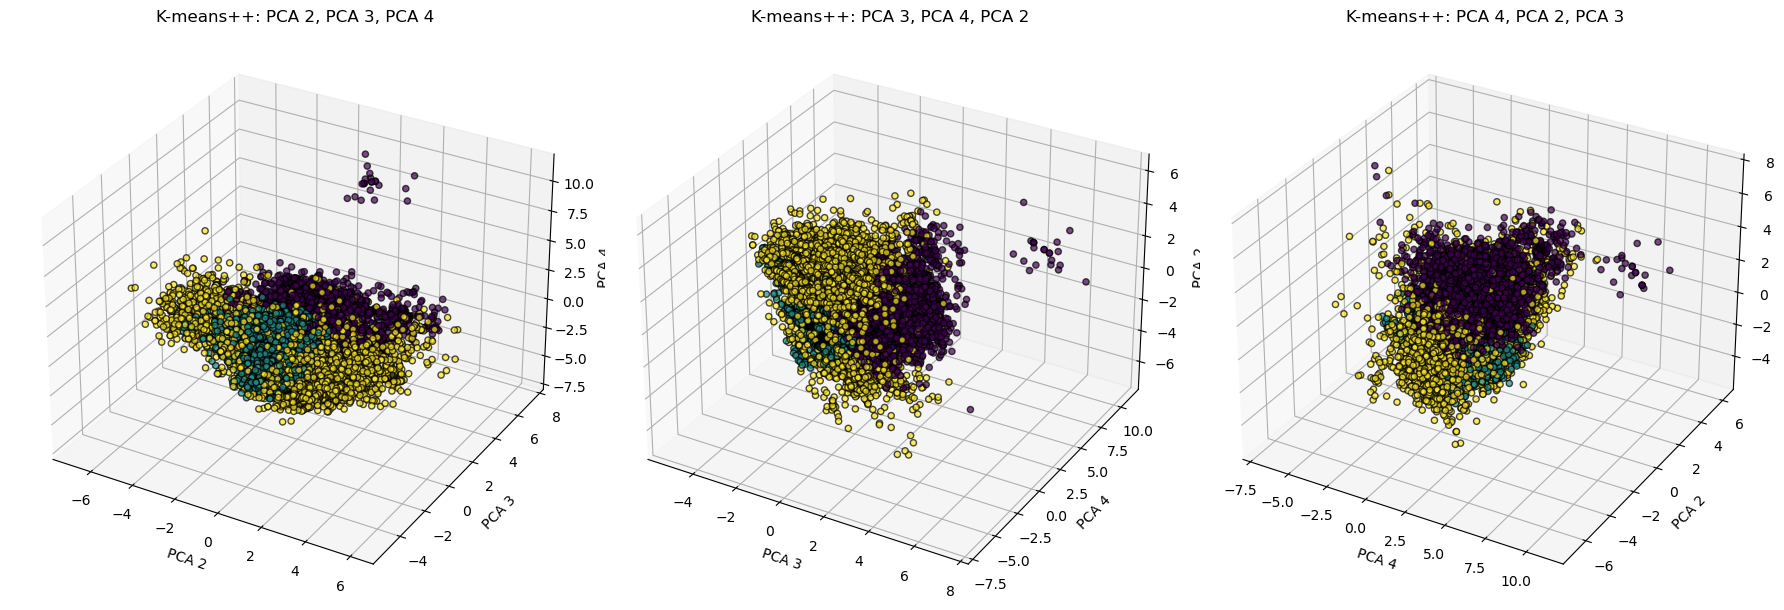

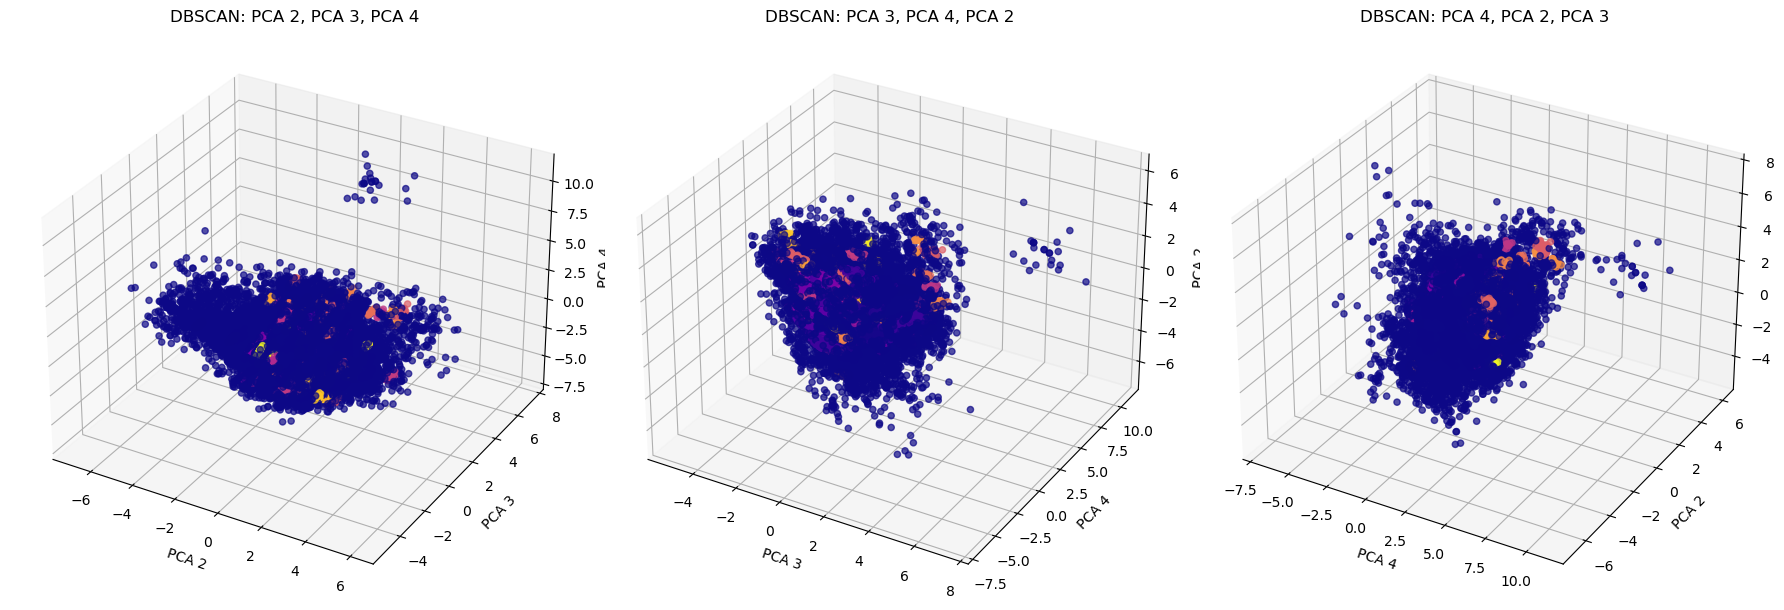

In [129]:
selected_combinations3 = [
    (1, 2, 3),  # PCA 2, PCA 3, PCA 4
    (2, 3, 1),  # PCA 3, PCA 4, PCA 2
    (3, 1, 2)   # PCA 4, PCA 2, PCA 3
]

# plot the clusters of K-means++
fig = plt.figure(figsize=(18, 6))  
for i, (x_idx, y_idx, z_idx) in enumerate(selected_combinations3):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')  
    
    # Scatter plot of K-means++
    ax.scatter(
        X_pca3[:, x_idx], X_pca3[:, y_idx], X_pca3[:, z_idx],
        c=labels3, cmap='viridis', alpha=0.7, edgecolor='k'
    )
    
    # title and labels
    ax.set_title(f'K-means++: PCA {x_idx+1}, PCA {y_idx+1}, PCA {z_idx+1}')
    ax.set_xlabel(f'PCA {x_idx+1}')
    ax.set_ylabel(f'PCA {y_idx+1}')
    ax.set_zlabel(f'PCA {z_idx+1}')

plt.tight_layout()
plt.show()

# plot the clusters of DBSCAN
fig = plt.figure(figsize=(18, 6))  
for i, (x_idx, y_idx, z_idx) in enumerate(selected_combinations3):
    ax = fig.add_subplot(1, 3, i + 1, projection='3d')  
    
    # Scatter plot of DBSCAN
    ax.scatter(
        X_pca3[:, x_idx], X_pca3[:, y_idx], X_pca3[:, z_idx],
        c=labels_dbscan3, cmap='plasma', alpha=0.7
    )
    
    # title and labels
    ax.set_title(f'DBSCAN: PCA {x_idx+1}, PCA {y_idx+1}, PCA {z_idx+1}')
    ax.set_xlabel(f'PCA {x_idx+1}')
    ax.set_ylabel(f'PCA {y_idx+1}')
    ax.set_zlabel(f'PCA {z_idx+1}')

plt.tight_layout()
plt.show()


# ***2.4 What is the best algorithm?***

### ***To answer this question properly we have to compare three different metrics applied to the three different Algorithms we used in our anlysis:***

- Silhouette Score (we have seen it before) = Measures the compactness and separation of clusters. The score varies between -1 and 1. It says how well each point is in its own cluster compared to the nearest cluster ;
- Davies-Bouldin Index = Evaluates the compactness and separation of the clusters. A lower value indicates better defined clusters. Ratio between intra-cluster and inter-cluster distance ;
- Calinski-Harabasz Index = Evaluates the relationship between inter-cluster and intra-cluster variance. A higher value indicates well-defined clusters. The density of the clusters compared to their mutual distance.

--- 

#### Silhouette Score: ***$s = \frac{b - a}{\max(a, b)}$***

---

#### Davies-Bouldin Index: ***$DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \frac{\sigma_i + \sigma_j}{d_{ij}}$***

---

#### Calinski-Harabasz Index: ***$CH = \frac{\text{tr}(B)}{\text{tr}(W)} \cdot \frac{n - k}{k - 1}$***

In [130]:
# metrics evaluation
for name, labels in [("K-means++", labels3), ("K-means", labels_case3), ("DBSCAN", labels_dbscan3)]:
    
    # Ignore noise points for DBSCAN
    valid_labels = labels[labels != -1] if name == "DBSCAN" else labels
    valid_data = X_pca3[labels != -1] if name == "DBSCAN" else X_pca3

    silhouette = silhouette_score(valid_data, valid_labels)
    davies_bouldin = davies_bouldin_score(valid_data, valid_labels)
    calinski_harabasz = calinski_harabasz_score(valid_data, valid_labels)
    
    print(f"{name}:")
    print(f"  Silhouette Score: {silhouette:.4f}")
    print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"  Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    print()  #to leave a blank space

K-means++:
  Silhouette Score: 0.1578
  Davies-Bouldin Index: 1.7856
  Calinski-Harabasz Index: 5560.4594

K-means:
  Silhouette Score: 0.2888
  Davies-Bouldin Index: 1.4033
  Calinski-Harabasz Index: 6566.9221

DBSCAN:
  Silhouette Score: 0.3055
  Davies-Bouldin Index: 0.7161
  Calinski-Harabasz Index: 1281.1415



### ***Let's analyze the results:***

1) If priority is the quality of the clusters (Silhouette and Davies-Bouldin) --> **DBSCAN** is the best because it identifies more defined clusters than the other methods ;

2) If priority is the separation and cohesion of clusters (Calinski-Harabasz) --> KMeans++ is the best, clusters are more compact and separated ;

3) **KMeans** and **Kmeans++** have almost the same results.

---

### ***So, what is the best algorithm?***

In our case, we can say that the best algorithm for clustering is `DBSCAN`

# 3. Bonus Question

**Understanding the Data:**
   - we use `movies_1c` previously defined
   - `movies_1c.head()` displays the first few rows of the dataset, helping us understand its structure and content.
   - `movies_1c.columns` lists the column names, allowing us to identify the available variables.


In [152]:
movies_1c.head(), movies_1c.columns

(   ratings_avg  (no genres listed)    Action  Adventure  Animation  Children  \
 0     1.198467                   0 -0.384916   3.272969   5.055775  4.790520   
 1     0.119805                   0 -0.384916   3.272969  -0.197794  4.790520   
 2     0.027132                   0 -0.384916  -0.305533  -0.197794 -0.208746   
 3    -0.413369                   0 -0.384916  -0.305533  -0.197794 -0.208746   
 4    -0.104341                   0 -0.384916  -0.305533  -0.197794 -0.208746   
 
      Comedy     Crime  Documentary     Drama  ...    Sci-Fi  Thriller  \
 0  1.502486 -0.347495    -0.315609 -0.978600  ... -0.261265 -0.425283   
 1 -0.665564 -0.347495    -0.315609 -0.978600  ... -0.261265 -0.425283   
 2  1.502486 -0.347495    -0.315609 -0.978600  ... -0.261265 -0.425283   
 3  1.502486 -0.347495    -0.315609  1.021868  ... -0.261265 -0.425283   
 4  1.502486 -0.347495    -0.315609 -0.978600  ... -0.261265 -0.425283   
 
         War  Western  ratings_count  release_year  genre_count  \

### Explanations:
#### Tracking Centroids in K-Means Clustering
1. **Function Definition:**
   - `kmeans_iteration_tracking`: Manually implements the K-means algorithm on the given dataset and tracks the cluster centroids at each iteration.
   - Initially, random points are assigned as cluster centroids.
   - Data points are assigned to the nearest centroid based on distance.
   - New centroids are recalculated as the mean of the assigned points in each cluster.
   - If the centroids do not change (convergence is achieved), the algorithm stops.

2. **Function Outputs:**
   - `centroids_history`: A history of centroids computed at each iteration.
   - `cluster_assignments`: The cluster to which each data point is assigned.

3. **Running Clustering:**
   - `n_clusters`: The number of clusters is set to 3.
   - `selected_features`: Two selected features (e.g., ratings_avg and ratings_count) are used for clustering.

4. **Visualizing Centroid Progression:**
   - Shows the change in cluster centroids at each iteration using a line plot.
   - Different colors are used for each cluster to distinguish them.
   - Data points are colored based on their cluster assignments.

5. **Plot Details:**
   - X-Axis: Ratings Average
   - Y-Axis: Ratings Count
   - Plot Title: "K-means Cluster Progression (Manual Implementation)"
   - Legend: Each cluster is represented by a different color.

In [157]:
selected_features = movies_1c[["ratings_avg", "ratings_count"]].values

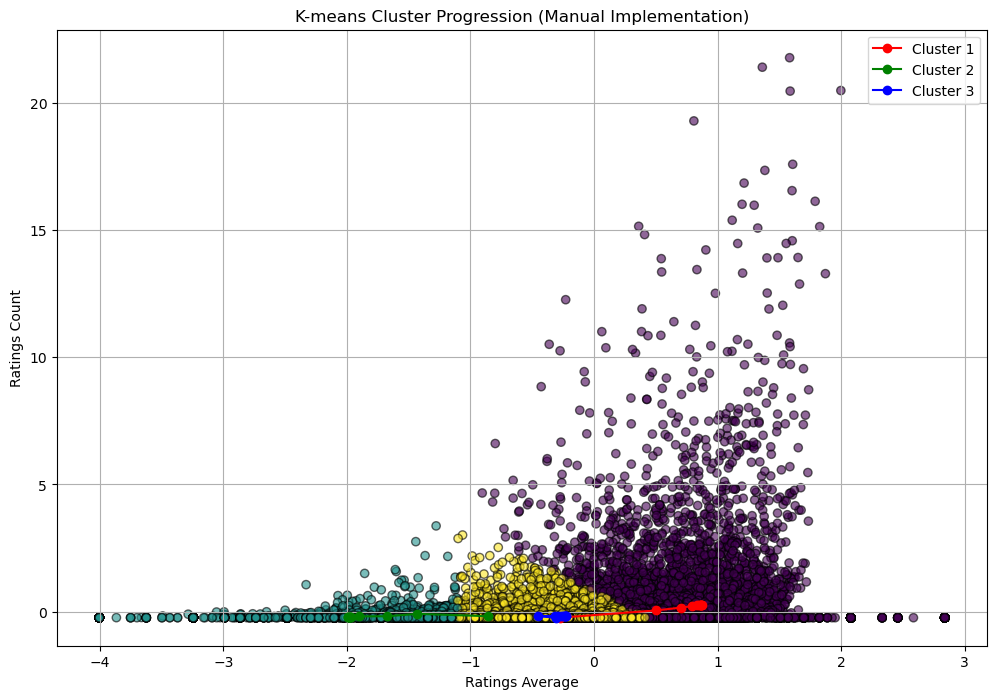

In [158]:
def kmeans_iteration_tracking(data, n_clusters, max_iters=10):
    np.random.seed(42)

    centroids = data[np.random.choice(data.shape[0], n_clusters, replace=False)]
    centroids_history = [centroids.copy()]

    for _ in range(max_iters):

        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        cluster_assignments = np.argmin(distances, axis=1)

        new_centroids = np.array([data[cluster_assignments == k].mean(axis=0) for k in range(n_clusters)])

        if np.allclose(new_centroids, centroids):
            break
        centroids = new_centroids
        centroids_history.append(centroids.copy())

    return centroids_history, cluster_assignments

n_clusters = 3
centroids_history, cluster_assignments = kmeans_iteration_tracking(selected_features, n_clusters)

centroids_history = np.array(centroids_history)

plt.figure(figsize=(12, 8))
colors = ['r', 'g', 'b']
for cluster_idx in range(n_clusters):
    plt.plot(
        centroids_history[:, cluster_idx, 0],
        centroids_history[:, cluster_idx, 1],
        '-o',
        label=f'Cluster {cluster_idx + 1}',
        color=colors[cluster_idx]
    )

# Plot the data points
plt.scatter(selected_features[:, 0], selected_features[:, 1], c=cluster_assignments, cmap='viridis', alpha=0.6, edgecolor='k')

plt.title("K-means Cluster Progression (Manual Implementation)")
plt.xlabel("Ratings Average")
plt.ylabel("Ratings Count")
plt.legend()
plt.grid()
plt.show()


### Explanations:
#### Dimensionality Reduction and Identifying Important Components with PCA
1. **Applying PCA:**
   - `PCA(n_components=2)`: Reduces the dataset's dimensionality to two components.
   - `pca.fit_transform(selected_features)`: Applies PCA to the selected features and creates a new dataset with reduced dimensions (`pca_features`).

2. **Explained Variance Ratio:**
   - `explained_variance_ratio_`: Indicates how much of the total variance is explained by each principal component.
   - This ratio helps to identify the importance of each component in the dataset.

3. **Visualizing Variance Ratio:**
   - `sns.barplot`: Visualizes the explained variance ratios of the principal components as a bar plot.
   - X-Axis: Principal components (PC1 and PC2).
   - Y-Axis: Explained variance ratio for each component.
   - Plot Title: "Explained Variance Ratio for Selected Features (PCA)".

4. **Verification and Analysis:**
   - `explained_variance_ratio`: Prints the variance ratios to verify the impact of each component numerically.

This process helps to understand which components are most significant for analysis and visualize the impact of dimensionality reduction.

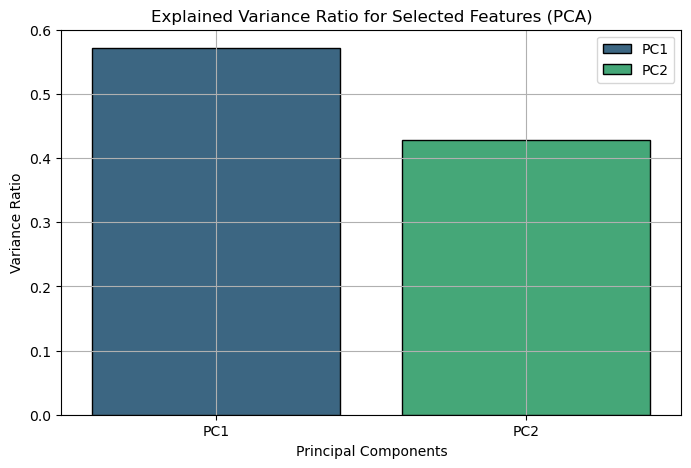

array([0.57154882, 0.42845118])

In [172]:
# Perform PCA to reduce dimensionality and identify important components
pca = PCA(n_components=2)
pca_features = pca.fit_transform(selected_features)


explained_variance_ratio = pca.explained_variance_ratio_


plt.figure(figsize=(8, 5))
sns.barplot(x=["PC1", "PC2"], y=explained_variance_ratio, hue=["PC1", "PC2"], palette="viridis", dodge=False, edgecolor="black")
plt.title("Explained Variance Ratio for Selected Features (PCA)")
plt.ylabel("Variance Ratio")
plt.xlabel("Principal Components")
plt.grid()
plt.show()

# Output principal components for verification
explained_variance_ratio


#### PCA analysis results show that the first two main variables (PC1 and PC2) explain 100% of the total variance:

* PC1: Explains 57.15% of the variance.
* PC2: Explains 42.85% of the variance.

### Explanations:
#### Tracking Centroids in K-Means Clustering
1. **Function Definition:**
   - `kmeans_iteration_tracking`: Manually implements the K-means algorithm on the given dataset and tracks the cluster centroids at each iteration.
   - Initially, random points are assigned as cluster centroids.
   - Data points are assigned to the nearest centroid based on distance.
   - New centroids are recalculated as the mean of the assigned points in each cluster.
   - If the centroids do not change (convergence is achieved), the algorithm stops.

2. **Function Outputs:**
   - `centroids_history`: A history of centroids computed at each iteration.
   - `cluster_assignments`: The cluster to which each data point is assigned.

3. **Running Clustering:**
   - `n_clusters`: The number of clusters is set to 3.
   - `selected_features`: Two selected features (e.g., ratings_avg and ratings_count) are used for clustering.

4. **Visualizing Centroid Progression:**
   - Shows the change in cluster centroids at each iteration using a line plot.
   - Different colors are used for each cluster to distinguish them.
   - Data points are colored based on their cluster assignments.

5. **Plot Details:**
   - X-Axis: Ratings Average
   - Y-Axis: Ratings Count
   - Plot Title: "K-means Cluster Progression (Manual Implementation)"
   - Legend: Each cluster is represented by a different color.

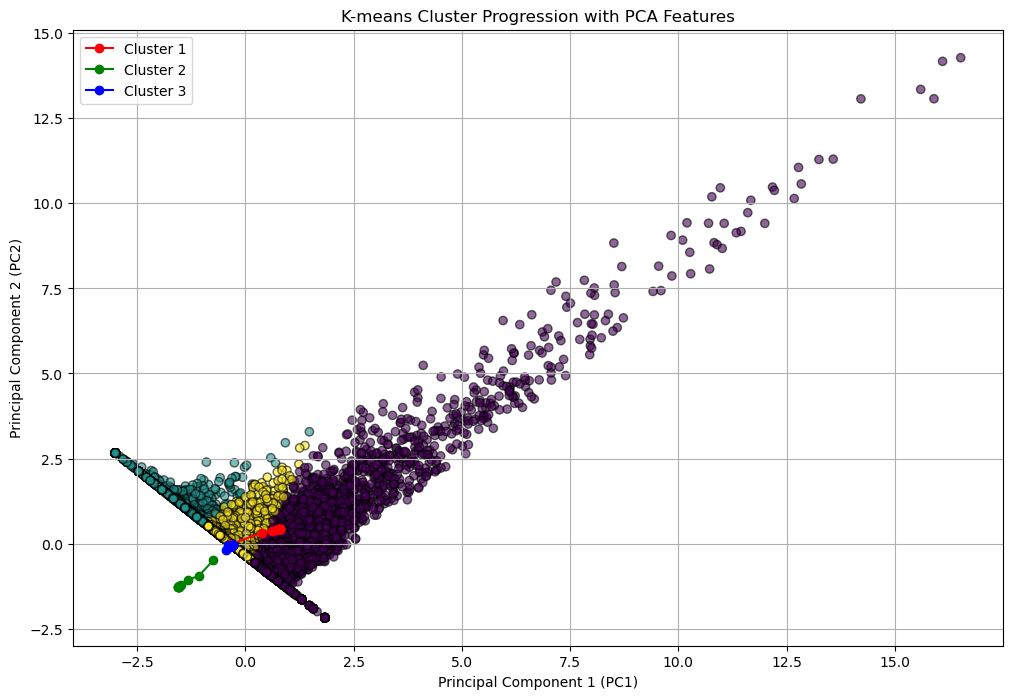

In [169]:
n_clusters = 3
centroids_history_pca, cluster_assignments_pca = kmeans_iteration_tracking(pca_features, n_clusters)

centroids_history_pca = np.array(centroids_history_pca)

plt.figure(figsize=(12, 8))
colors = ['r', 'g', 'b']
for cluster_idx in range(n_clusters):
    plt.plot(
        centroids_history_pca[:, cluster_idx, 0],
        centroids_history_pca[:, cluster_idx, 1],
        '-o',
        label=f'Cluster {cluster_idx + 1}',
        color=colors[cluster_idx]
    )
pca_features[:, 1] = -pca_features[:, 1]
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_assignments_pca, cmap='viridis', alpha=0.6, edgecolor='k')

plt.title("K-means Cluster Progression with PCA Features")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend()
plt.grid()
plt.show()


### Explanations :
#### Comparison of Clustering with Raw Features and PCA-Transformed Features
1. **Setting Up Subplots:**
   - `fig, axs = plt.subplots(1, 2, figsize=(18, 8))`: Creates two subplots, one for raw features and another for PCA-transformed features.

2. **Clustering with Raw Features (Left Plot):**
   - `axs[0].scatter`: Plots data points using raw features (ratings_avg and ratings_count) with cluster coloring.
   - `axs[0].plot`: Shows the movement of cluster centroids over iterations as a line plot.
   - X-Axis: Ratings Average.
   - Y-Axis: Ratings Count.
   - Plot Title: "Clustering Using Raw Features (Ratings Avg & Count)".
   - `axs[0].legend()`: Adds a legend to indicate the clusters.
   - `axs[0].grid()`: Adds grid lines for better visual clarity.

3. **Clustering with PCA Features (Right Plot):**
   - `axs[1].scatter`: Plots data points using PCA-transformed features (PC1 and PC2) with cluster coloring.
   - `axs[1].plot`: Shows the movement of cluster centroids with PCA features over iterations.
   - X-Axis: Principal Component 1 (PC1).
   - Y-Axis: Principal Component 2 (PC2).
   - Plot Title: "Clustering Using PCA-Transformed Features (PC1 & PC2)".
   - `axs[1].legend()`: Adds a legend for cluster centroids.
   - `axs[1].grid()`: Adds grid lines for better clarity.

4. **Layout and Display:**
   - `plt.tight_layout()`: Adjusts spacing between subplots for better layout.
   - `plt.show()`: Displays the plots.

This process visually compares the clustering results of raw features and PCA-transformed features.

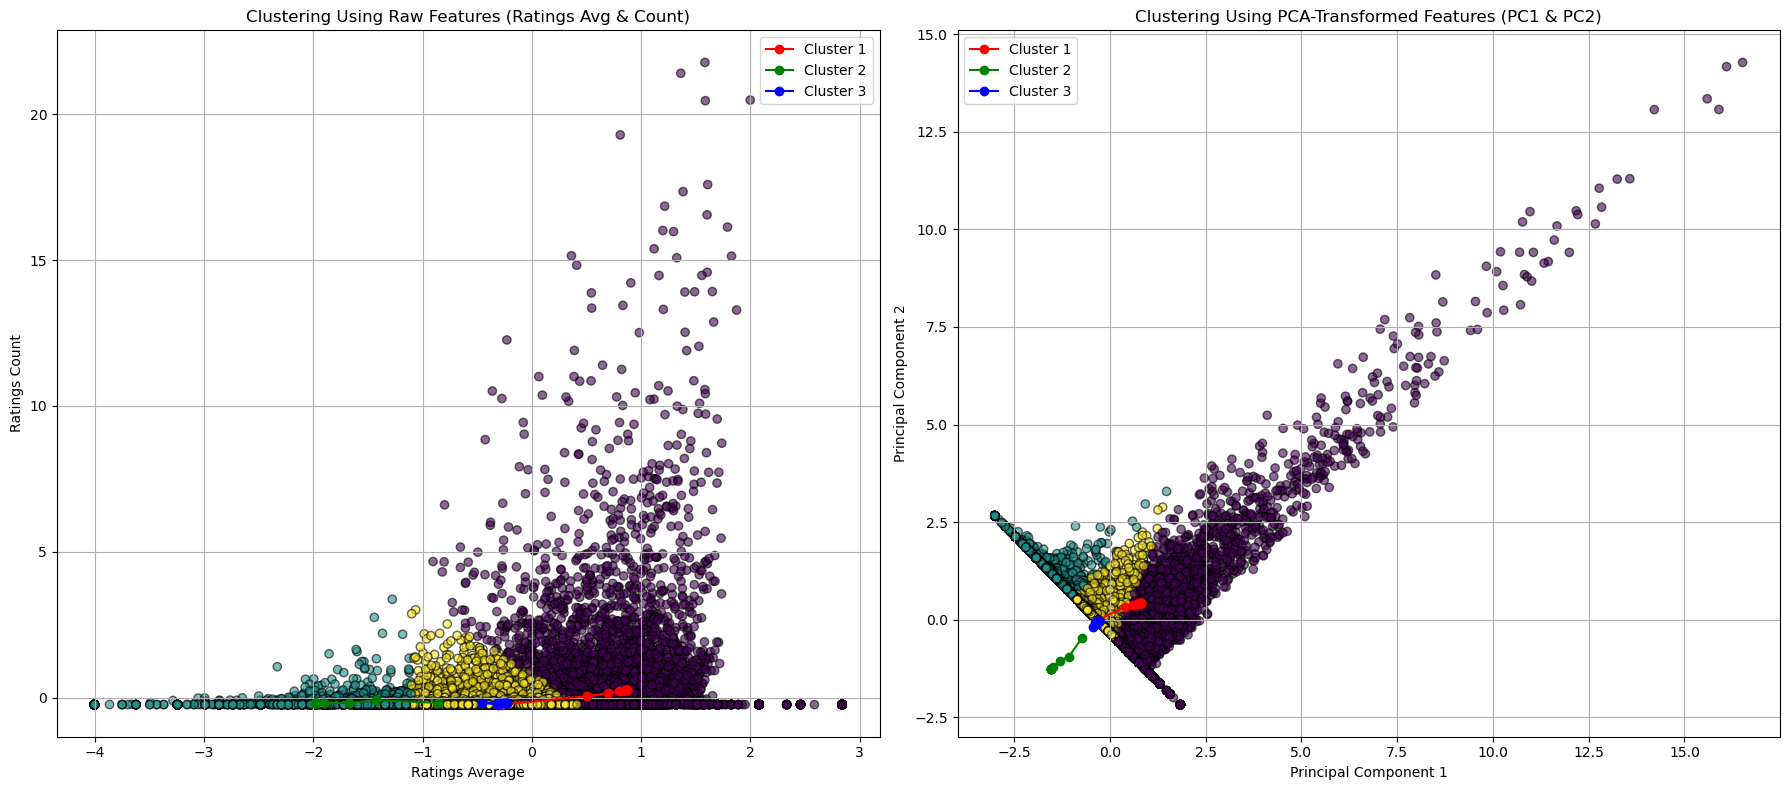

In [170]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

axs[0].scatter(selected_features[:, 0], selected_features[:, 1], c=cluster_assignments, cmap='viridis', alpha=0.6, edgecolor='k')
for cluster_idx in range(n_clusters):
    axs[0].plot(
        centroids_history[:, cluster_idx, 0],
        centroids_history[:, cluster_idx, 1],
        '-o',
        label=f'Cluster {cluster_idx + 1}',
        color=colors[cluster_idx]
    )
axs[0].set_title("Clustering Using Raw Features (Ratings Avg & Count)")
axs[0].set_xlabel("Ratings Average")
axs[0].set_ylabel("Ratings Count")
axs[0].legend()
axs[0].grid()

axs[1].scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_assignments_pca, cmap='viridis', alpha=0.6, edgecolor='k')
for cluster_idx in range(n_clusters):
    axs[1].plot(
        centroids_history_pca[:, cluster_idx, 0],
        centroids_history_pca[:, cluster_idx, 1],
        '-o',
        label=f'Cluster {cluster_idx + 1}',
        color=colors[cluster_idx]
    )
axs[1].set_title("Clustering Using PCA-Transformed Features (PC1 & PC2)")
axs[1].set_xlabel("Principal Component 1")
axs[1].set_ylabel("Principal Component 2")
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


# Comparison of Clustering Using Raw Features vs. PCA-Transformed Features

In this section, we compare clustering results based on **raw features** and **PCA-transformed features** to understand their differences and appropriate use cases.

## 1. Clustering with Raw Features (Left Graph)
### Variables:
- `ratings_avg` (average rating)
- `ratings_count` (number of ratings)

### Observations:
- The separation of clusters heavily depends on the scale of raw features.
- The differences in scales between features can cause clusters to appear more or less distinct, particularly in regions with high or low data density.
- Visualizing clusters with raw features is helpful for directly observing the influence of original variables on the clustering process.

## 2. Clustering with PCA-Transformed Features (Right Graph)
### Variables:
- `PC1` (Principal Component 1)
- `PC2` (Principal Component 2)

### Observations:
- PCA extracts new components that explain the maximum variance in the data.
- This transformation results in more compact and distinct visualizations of clusters.
- PCA is particularly effective in separating overlapping clusters, especially in high-dimensional datasets.

## Key Takeaways:
### When to Use Raw Features:
- When the goal is to interpret the direct impact of original features on clusters.
- Be cautious of differing feature scales, as they may skew clustering results.

### When to Use PCA-Transformed Features:
- When dealing with high-dimensional or complex datasets.
- PCA reduces dimensionality and highlights key variances, making clusters easier to distinguish.

## Conclusion:
In this comparison, clustering with PCA-transformed features results in clearer and more distinguishable clusters. However, the choice between using raw or PCA-transformed features depends on the objective of the analysis:
- If understanding the original features is crucial, use raw features.
- If you aim for better cluster separation or dimensionality reduction, PCA is the better choice.


### How Features Were Selected for Visualization
To select the most effective features for visualizing cluster separation, we used the following methodology:

1. **Feature Variance Analysis:**
   - Features with higher variance are typically more informative for clustering as they capture greater differences between data points. We reviewed the variance of each feature to prioritize those with significant differences across instances.

2. **Principal Component Analysis (PCA):**
   - When working with high-dimensional data, PCA was applied to reduce the dimensionality while retaining the maximum variance. The first two principal components (PC1 and PC2) were chosen as they explain the largest portion of the variance in the dataset.

3. **Domain Knowledge:**
   - In cases where PCA was not used, domain knowledge guided the selection of `ratings_avg` (average ratings) and `ratings_count` (number of ratings) as they are intuitive metrics for user engagement and movie popularity.

4. **Cluster Visualization:**
   - Features were evaluated based on their ability to visually separate clusters. This involved plotting different combinations of features and assessing their effectiveness in distinguishing clusters.

By combining statistical techniques like PCA and feature variance analysis with domain expertise, we ensured that the selected features (`ratings_avg`, `ratings_count`, and PCA components) were both meaningful and effective for visualizing cluster separation.


### Code Explanation:
This code is written to visualize the progression of K-means clustering over iterations using an animation.

#### Purpose:
- **Cluster Evolution Over Iterations:** To display how data points are assigned to clusters and how the cluster centroids move with each iteration.
- **Animation Creation:** Using `FuncAnimation` to create an animation of the changing cluster information over time and save it as a GIF.

MovieWriter ffmpeg unavailable; using Pillow instead.


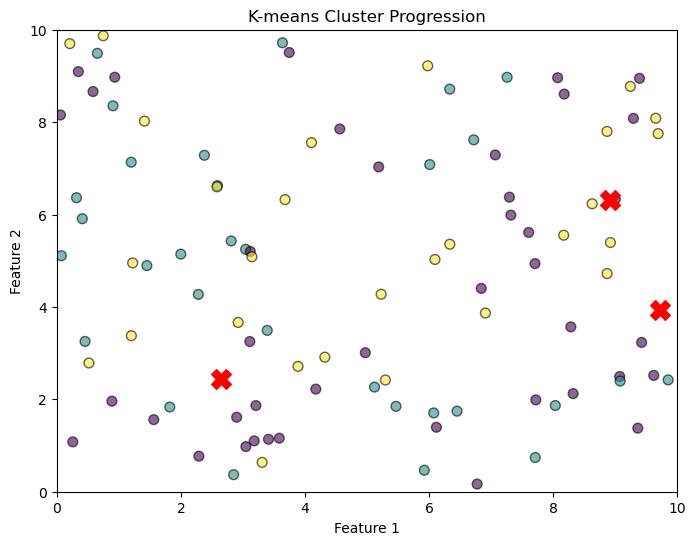

In [137]:
from matplotlib.animation import FuncAnimation

iterations = 5
num_points = 100
np.random.seed(42)

X = np.random.rand(num_points, 2) * 10
centroids_over_time = [np.random.rand(3, 2) * 10 for _ in range(iterations)]
cluster_assignments = [np.random.randint(0, 3, size=num_points) for _ in range(iterations)]

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter([], [], c=[], cmap='viridis', alpha=0.6, edgecolor='k', s=50)
centroid_sc = ax.scatter([], [], c='red', marker='X', s=200, label="Cluster Centers")

def init():
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_title("K-means Cluster Progression")
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")
    return sc, centroid_sc

def update(frame):
    sc.set_offsets(X)
    sc.set_array(cluster_assignments[frame])
    centroid_sc.set_offsets(centroids_over_time[frame])
    return sc, centroid_sc

ani = FuncAnimation(fig, update, frames=range(iterations), init_func=init, blit=True, repeat=False)

ani.save("kmeans_progress.gif", fps=1)

plt.show()


### Code Explanation:
* This code visualizes the movement of cluster centroids across iterations of the K-means clustering algorithm.
* This code visualizes the results of the K-means clustering algorithm, displaying data points and cluster centers. Additionally, it includes labels for each cluster center.
#### Purpose:
- **Visualizing Centroid Movements:** To display how the positions of the cluster centroids change across iterations on a plot.
- **Understanding the Clustering Process:** To analyze the assignments of data points to clusters and the iterative updates of centroids.
-  **Visualizing Clusters:** To clearly show the assignment of data points to clusters and the positions of cluster centers.
- **Adding Cluster Labels:** To annotate each cluster center with its respective label, indicating which cluster it represents.


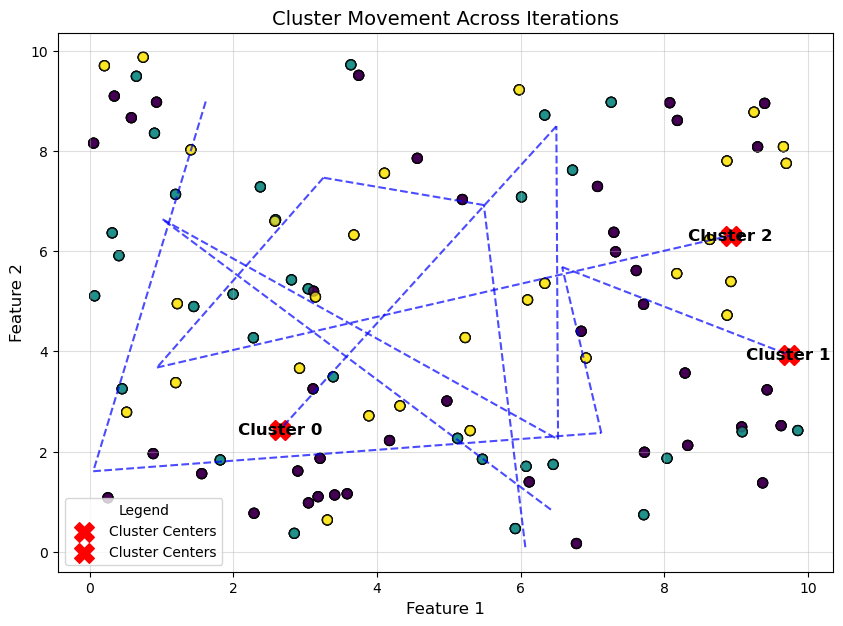

In [138]:
plt.figure(figsize=(10, 7))

plt.scatter(X[:, 0], X[:, 1], c=cluster_assignments[-1], cmap='viridis', alpha=0.7, edgecolor='k', s=50)

for i in range(len(centroids_over_time) - 1):
    plt.plot(
        [centroids_over_time[i][:, 0], centroids_over_time[i + 1][:, 0]],
        [centroids_over_time[i][:, 1], centroids_over_time[i + 1][:, 1]],
        color='blue', linestyle='--', alpha=0.7
    )
    plt.scatter(X[:, 0], X[:, 1], c=cluster_assignments[-1], cmap='viridis', alpha=0.7, edgecolor='k', s=50)
plt.scatter(centroids_over_time[-1][:, 0], centroids_over_time[-1][:, 1], c='red', marker='X', s=200, label="Cluster Centers")

for i, (x, y) in enumerate(centroids_over_time[-1]):
    plt.text(x, y, f"Cluster {i}", fontsize=12, color="black", weight="bold", ha='center', va='center')
plt.scatter(centroids_over_time[-1][:, 0], centroids_over_time[-1][:, 1], c='red', marker='X', s=200, label="Cluster Centers")
plt.title("Cluster Movement Across Iterations", fontsize=14)
plt.xlabel("Feature 1", fontsize=12)
plt.ylabel("Feature 2", fontsize=12)
plt.legend(title="Legend")
plt.grid(alpha=0.4)
plt.show()

# 4.0 Algorithmic Question

## Arya and Mario's Number Picking Game

### Problem Statement

Two brilliant strategists, Arya and Mario, are about to play a game with a sequence of numbers. Arya, as player 1, begins the game, while Mario, player 2, plays second. Their goal is clear: to collect the highest possible score by taking numbers from either end of the sequence, one at a time. They will play in perfect synchronicity, each seeking the advantage.

The sequence, represented as an array `nums`, is laid out in front of them. Arya will start by selecting either the number at the beginning (`nums[0]`) or the end (`nums[nums.length - 1]`) of the array, adding that value to her score. This value is then removed from the beginning or the end of `nums`. Then, it’s Mario’s turn to do the same with the remaining sequence. The game proceeds this way, with each player taking numbers from either end until no numbers are left to claim. The player with the highest score wins.

However, if they end in a tie, Arya, as the first to act, will claim victory by default.

### Task

Write a program that helps Arya predict her chances of winning. Given the sequence of numbers in the array `nums`, determine if Arya can guarantee a win, assuming both players play with perfect strategy.

### Input

- An array `nums` of length `n` (1 ≤ `n` ≤ 1000), where each element is an integer representing a number in the sequence. Each integer satisfies `0 ≤ nums[i] ≤ 10^6`.

### Output

- Return `True` if Arya can guarantee a win with optimal play. Otherwise, return `False`.

#### **a) Pseudocode for an Optimal Playing Strategy**
To determine the optimal strategy using recursion, the idea is to evaluate all possible moves (taking from the start or the end of the sequence) and choose the move that maximizes Arya's advantage, assuming both players play optimally.

**Pseudocode:**
```
function optimalStrategy(nums, start, end, turn):
    if start > end:
        return 0
    
    if turn == 1:  // Arya's turn
        pick_start = nums[start] + optimalStrategy(nums, start + 1, end, 2)
        pick_end = nums[end] + optimalStrategy(nums, start, end - 1, 2)
        return max(pick_start, pick_end)
    else:  // Mario's turn
        pick_start = -nums[start] + optimalStrategy(nums, start + 1, end, 1)
        pick_end = -nums[end] + optimalStrategy(nums, start, end - 1, 1)
        return min(pick_start, pick_end)
```

#### **b) Python Program Implementation**
Here is the implementation of the above pseudocode in Python:

```python
def can_arya_win(nums):
    def optimal_strategy(nums, start, end, turn):
        if start > end:
            return 0

        if turn == 1:  # Arya's turn
            pick_start = nums[start] + optimal_strategy(nums, start + 1, end, 2)
            pick_end = nums[end] + optimal_strategy(nums, start, end - 1, 2)
            return max(pick_start, pick_end)
        else:  # Mario's turn
            pick_start = -nums[start] + optimal_strategy(nums, start + 1, end, 1)
            pick_end = -nums[end] + optimal_strategy(nums, start, end - 1, 1)
            return min(pick_start, pick_end)

    return optimal_strategy(nums, 0, len(nums) - 1, 1) >= 0

# Test cases
print(can_arya_win([1, 5, 2]))  # Output: False
print(can_arya_win([1, 5, 233, 7]))  # Output: True
```

#### **c) Efficiency of the Algorithm**
The algorithm evaluates all possible combinations of moves recursively. For each move, it evaluates two possible subproblems, leading to an exponential time complexity.

**Time Complexity:**
- Let \( n \) be the length of the array.
- In the worst case, the recursion tree has \( 2^n \) nodes (each level splits into two branches).
- **Complexity:** \( O(2^n) \).

#### **d) Making the Algorithm Polynomial**
The recursive algorithm can be optimized using **Dynamic Programming (DP)** by storing previously computed results in a 2D table to avoid redundant calculations.

**Pseudocode for DP:**
```
function optimalStrategyDP(nums):
    n = len(nums)
    dp = [[0] * n for _ in range(n)]

    for gap in range(n):  // Gap represents the difference between start and end indices
        for start in range(n - gap):
            end = start + gap
            if start == end:
                dp[start][end] = nums[start]
            else:
                pick_start = nums[start] - dp[start + 1][end]
                pick_end = nums[end] - dp[start][end - 1]
                dp[start][end] = max(pick_start, pick_end)

    return dp[0][n - 1] >= 0
```

#### **e) Python Implementation with DP**
Here is the implementation of the DP algorithm:

```python
def can_arya_win_dp(nums):
    n = len(nums)
    dp = [[0] * n for _ in range(n)]

    for gap in range(n):
        for start in range(n - gap):
            end = start + gap
            if start == end:
                dp[start][end] = nums[start]
            else:
                pick_start = nums[start] - dp[start + 1][end]
                pick_end = nums[end] - dp[start][end - 1]
                dp[start][end] = max(pick_start, pick_end)

    return dp[0][n - 1] >= 0

# Test cases
print(can_arya_win_dp([1, 5, 2]))  # Output: False
print(can_arya_win_dp([1, 5, 233, 7]))  # Output: True
```

**Complexity:**
- Time Complexity: \( O(n^2) \) — Each subproblem is solved once.
- Space Complexity: \( O(n^2) \).

#### **f) Optimized Implementation Using LLM**
Let’s craft an optimized solution using insights from an LLM and analyze its performance.

```python
def can_arya_win_llm(nums):
    n = len(nums)
    dp = [0] * n

    for end in range(n - 1, -1, -1):
        prev = 0
        for start in range(end, n):
            if start == end:
                dp[start] = nums[start]
            else:
                pick_start = nums[start] - prev
                pick_end = nums[end] - dp[start]
                prev = dp[start]
                dp[start] = max(pick_start, pick_end)

    return dp[n - 1] >= 0

# Test cases
print(can_arya_win_llm([1, 5, 2]))  # Output: False
print(can_arya_win_llm([1, 5, 233, 7]))  # Output: True
```

**Analysis:**
- **Time Complexity:** \( O(n^2) \) — Similar to the DP solution.
- **Space Complexity:** \( O(n) \) — Uses a single 1D array instead of a 2D matrix.

**Evaluation of LLM Solution:**
- The LLM improved space efficiency by reducing the 2D DP table to a 1D array while maintaining correctness.
- To validate correctness, compare outputs with the original solution for a variety of test cases.


In [139]:
def can_arya_win_dp(nums):
    n = len(nums)
    dp = [[0] * n for _ in range(n)]

    for gap in range(n):
        for start in range(n - gap):
            end = start + gap
            if start == end:
                dp[start][end] = nums[start]
            else:
                pick_start = nums[start] - dp[start + 1][end]
                pick_end = nums[end] - dp[start][end - 1]
                dp[start][end] = max(pick_start, pick_end)

    return dp[0][n - 1] >= 0

# Test cases
print(can_arya_win_dp([1, 5, 2]))  # Output: False
print(can_arya_win_dp([1, 5, 233, 7]))  # Output: True

False
True


In [140]:
def can_arya_win_dp(nums):
    n = len(nums)
    dp = [[0] * n for _ in range(n)]

    for gap in range(n):
        for start in range(n - gap):
            end = start + gap
            if start == end:
                dp[start][end] = nums[start]
            else:
                pick_start = nums[start] - dp[start + 1][end]
                pick_end = nums[end] - dp[start][end - 1]
                dp[start][end] = max(pick_start, pick_end)

    return dp[0][n - 1] >= 0

# Test cases
print(can_arya_win_dp([1, 5, 2]))  # Output: False
print(can_arya_win_dp([1, 5, 233, 7]))  # Output: True

False
True


In [141]:
def can_arya_win_llm(nums):
    n = len(nums)
    dp = [0] * n

    for end in range(n - 1, -1, -1):
        prev = 0
        for start in range(end, n):
            if start == end:
                dp[start] = nums[start]
            else:
                pick_start = nums[start] - prev
                pick_end = nums[end] - dp[start]
                prev = dp[start]
                dp[start] = max(pick_start, pick_end)

    return dp[n - 1] >= 0

# Test cases
print(can_arya_win_llm([1, 5, 2]))  # Output: False
print(can_arya_win_llm([1, 5, 233, 7]))  # Output: True

False
True
